Loading dataset...
Dataset loaded successfully. Shape: (2270317, 88)
Loading Global model...
Loading Edge model...


Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 175us/step
Fused core layer accuracy: 0.9698

Fused Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573665
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270317
   macro avg       0.98      0.95      0.96   2270317
weighted avg       0.97      0.97      0.97   2270317


Fused Core Confusion Matrix:
[[1573568      97]
 [  68418  628234]]


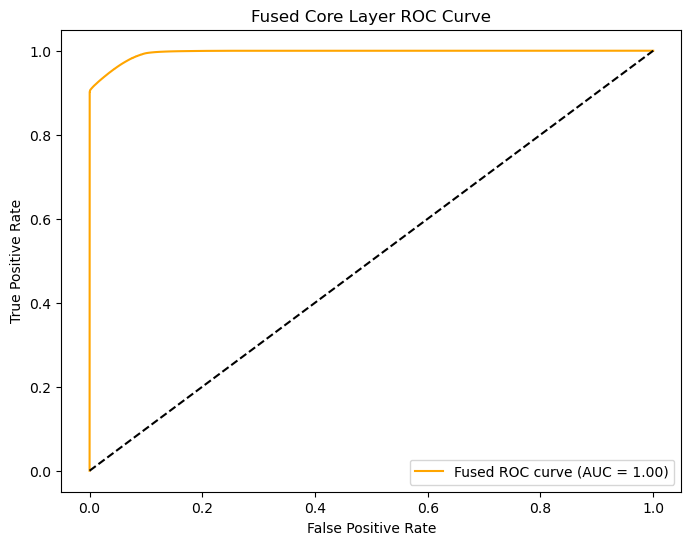

Core layer fusion results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv

Core layer fusion complete. Proceed with these results to build your final decision-making (core) layer.


In [18]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score

# ----------------------------------------------------------------
# Step 0: Define paths and directories
# ----------------------------------------------------------------
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

DATA_PATH         = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# ----------------------------------------------------------------
# Step 1: Load dataset and define any shared features
# ----------------------------------------------------------------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For demonstration, let's assume we only need 'Label' or 'Binary_Label' for final evaluation
# and that each layer had its own separate code for selecting features. We'll unify indexing carefully.

# If you have a 'Binary_Label' column for Attack vs. Benign:
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

# ----------------------------------------------------------------
# Step 2: Load the three models
# ----------------------------------------------------------------
print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)      # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)   # MLP

# ----------------------------------------------------------------
# Step 3: Generate predictions from each layer
# ----------------------------------------------------------------
# A) GLOBAL LAYER
#   In your original code, you had a specific set of 'global_features' for XGBoost.
#   We must replicate that EXACT feature subset and transformations (scaling if used).
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]

X_global = df[global_features].values
# If you had any scaler for XGB, apply it. If not, just proceed:
y_pred_proba_global = xgb_global.predict_proba(X_global)  # shape (N, num_classes)
# For a multi-class XGB, let's define an "attack confidence" = 1 - P(Benign).
# We'll find the index for "Benign" from label_encoder if needed.
# Alternatively, if "Benign" is class 0, we can do (1 - prob[:, 0]).
# Let's do a quick approach: find index of "Benign" in xgb_global.classes_ if you stored them:
# But if you used your own label_encoder, let's replicate that:
unique_labels = xgb_global.classes_  # This is the numeric-encoded classes in ascending order
# Actually, with 'objective=multi:softmax', xgb_global.classes_ might not be the same as strings
# so we must rely on your original label_encoder from training. Let's assume "Benign" was index 0:
# We'll do a hacky approach: if you know that label_encoder.classes_[0] = "Benign", then:
# or you can do:
# idx_benign = np.where(label_encoder.classes_ == "Benign")[0][0]

# For demonstration, let's assume "Benign" is index 0:
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# B) EDGE LAYER (LSTM)
#   The LSTM expects sequences. In your original code, you had a sliding window of length=5.
#   We'll replicate that logic. Then we do model.predict(...) to get shape (N_seq, num_classes).
#   We'll align the predictions with the original row indexing by skipping the first (sequence_length-1) rows, etc.

# Edge features used:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
# If you used a scaler for edge features, apply it now:
# Suppose you have joblib.load(...) for edge scaler or the same StandardScaler, just re-fit:
# For demonstration, we do a quick approach (but your real code must replicate the training scaling):
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)  # or load from file

sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i : i+sequence_length] for i in range(num_samples_edge)])
# Now get predictions:
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)  # shape (num_samples_edge, num_classes)
# For a multi-class, define "attack confidence" = 1 - prob_of_benign
# We assume "Benign" is index 0 again:
attack_conf_edge = 1.0 - edge_proba[:, 0]

# But we must align them with the original row indexing. The first 4 rows (sequence_length-1) won't have an LSTM pred.
# So effectively, we have 0..(num_samples_edge-1) which correspond to row indices 4..(N-1).
# We'll define an array of length N with placeholders for the first 4. Let's do:
attack_conf_edge_aligned = np.zeros(X_edge.shape[0])  # shape = N
attack_conf_edge_aligned[:sequence_length-1] = np.nan  # or 0, but better to mark them as not available
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge

# C) DEVICE LAYER (MLP)
#   You used a different set of device_features. We'll replicate that. Then do model.predict(...).
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
# If you had a saved scaler for device features, load it. We'll do a quick approach:
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)

device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
# This is a binary classification => device_proba = Probability(attack).
# If it's truly Probability(attack), then we can define:
attack_conf_device = device_proba  # already the probability of Attack
# or if it was Probability(benign), do (1 - device_proba)

# ----------------------------------------------------------------
# Step 4: Align all 3 sets of predictions
# ----------------------------------------------------------------
# We have N = df.shape[0] = 2,270,317 (in your data).
# - Global: we have 2,270,317 predictions (assuming no sliding window).
# - Edge: we have (N - 4) predictions, aligned from row=4..(N-1).
# - Device: we have N predictions.

# For the edge-lstm, we set the first 4 to NaN. So let's define a final array for each model:
attack_conf_global = np.array(attack_conf_global)  # shape (N,)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)  # shape (N,)
attack_conf_device = np.array(attack_conf_device)  # shape (N,)

# Some rows might have NaN from the edge-lstm. You can either:
#   (a) discard them in the final fusion
#   (b) treat NaN as 0
#   (c) or only fuse where all are valid
# For demonstration, let's do a simple approach: treat NaN as 0
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# ----------------------------------------------------------------
# Step 5: Weighted Fusion
# ----------------------------------------------------------------
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_score = (w_global * attack_conf_global
             + w_edge   * attack_conf_edge_aligned
             + w_device * attack_conf_device)

# We'll define a threshold=0.5
fused_label = (fused_score > 0.5).astype(int)

# ----------------------------------------------------------------
# Step 6: Evaluate if we have ground truth for the entire dataset
# ----------------------------------------------------------------
# If "Binary_Label" is 0=benign, 1=attack in df:
y_true = df["Binary_Label"].values  # shape (N,)

# Let's do a simple check that the shape matches:
assert len(y_true) == len(fused_label), "Mismatch in lengths!"

acc_core = accuracy_score(y_true, fused_label)
print(f"Fused core layer accuracy: {acc_core:.4f}")

print("\nFused Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))

cm_core = confusion_matrix(y_true, fused_label)
print("\nFused Core Confusion Matrix:")
print(cm_core)

# We'll define a threshold=0.5
fused_label = (fused_score > 0.5).astype(int)

# Plot a fused ROC
y_true_bin = y_true  # already 0 or 1
fpr_fused, tpr_fused, _ = roc_curve(y_true_bin, fused_score)
roc_auc_fused = auc(fpr_fused, tpr_fused)

plt.figure(figsize=(8,6))
plt.plot(fpr_fused, tpr_fused, color='orange', label=f"Fused ROC curve (AUC = {roc_auc_fused:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fused Core Layer ROC Curve")
plt.legend(loc="lower right")

# Instead of DEVICE_MODEL_DIR, define CORE_LAYER_DIR
plt.savefig(os.path.join(CORE_LAYER_DIR, "core_layer_fused_roc.png"))
plt.show()

# ----------------------------------------------------------------
# Step 7: Save final CSV
# ----------------------------------------------------------------
core_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf":   attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score": fused_score,
    "Fused_Label": fused_label,
    "True_Label":  y_true
})
csv_core_path = os.path.join(CORE_LAYER_DIR, "core_layer_results.csv")
core_results_df.to_csv(csv_core_path, index=False)
print(f"Core layer fusion results saved to: {csv_core_path}")

print("\nCore layer fusion complete. Proceed with these results to build your final decision-making (core) layer.")

In [22]:
import pandas as pd

# Load the core layer results
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df_core = pd.read_csv(csv_path)

# Display basic info
print("Dataset loaded. Shape:", df_core.shape)
df_core.head()

Dataset loaded. Shape: (2270317, 6)


,Global_Conf,Edge_Conf,Device_Conf,Fused_Score,Fused_Label,True_Label
0,0.000269,0.000000,6.871905e-21,0.000081,0,0
1,0.000408,0.000000,1.236284e-19,0.000122,0,0
2,0.000565,0.000000,4.224371e-19,0.000169,0,0
3,0.000280,0.000000,6.873583e-21,0.000084,0,0
4,0.000398,0.057688,1.236233e-19,0.017426,0,0


In [24]:
# Check for nulls (especially from Edge_LSTM alignment)
missing = df_core.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 Global_Conf    0
Edge_Conf      0
Device_Conf    0
Fused_Score    0
Fused_Label    0
True_Label     0
dtype: int64


In [26]:
# Basic stats for each layer's confidence
df_core[["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"]].describe()

,Global_Conf,Edge_Conf,Device_Conf,Fused_Score
count,2.270317e+06,2.270317e+06,2.270317e+06,2.270317e+06
mean,3.068584e-01,3.073766e-01,3.036616e-01,3.057352e-01
std,4.375960e-01,4.299994e-01,4.320944e-01,4.311109e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.741814e-06,2.506256e-03,1.319063e-08,1.124883e-02
50%,4.935265e-05,6.659597e-02,6.620064e-02,4.404398e-02
75%,9.999977e-01,9.999968e-01,9.998780e-01,9.999489e-01
max,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00


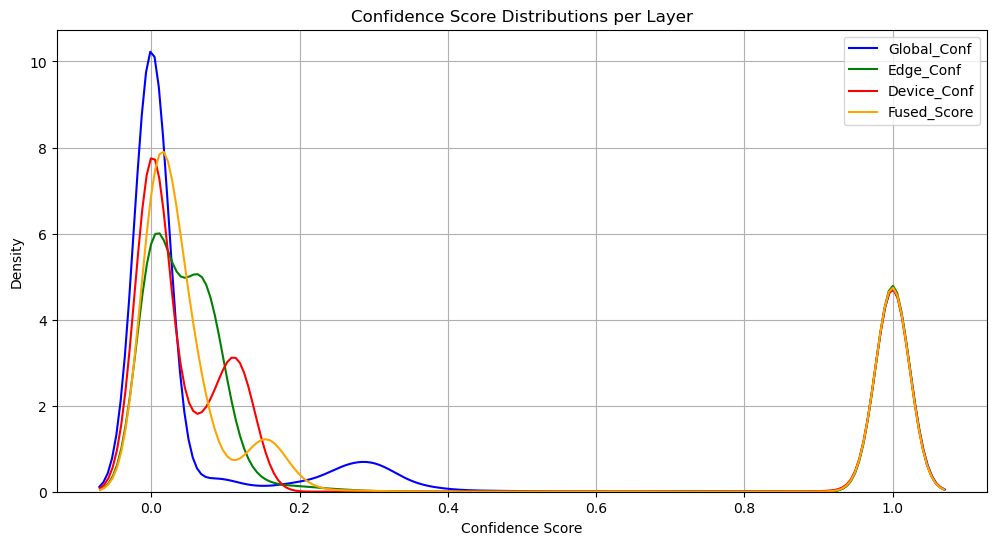

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
for col, color in zip(["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"],
                      ["blue", "green", "red", "orange"]):
    sns.kdeplot(df_core[col], label=col, color=color)

plt.title("Confidence Score Distributions per Layer")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Define FP, FN, TP, TN
df_core["FP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 0))
df_core["FN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 1))
df_core["TP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 1))
df_core["TN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 0))

print("False Positives:", df_core["FP"].sum())
print("False Negatives:", df_core["FN"].sum())

False Positives: 97
False Negatives: 68418


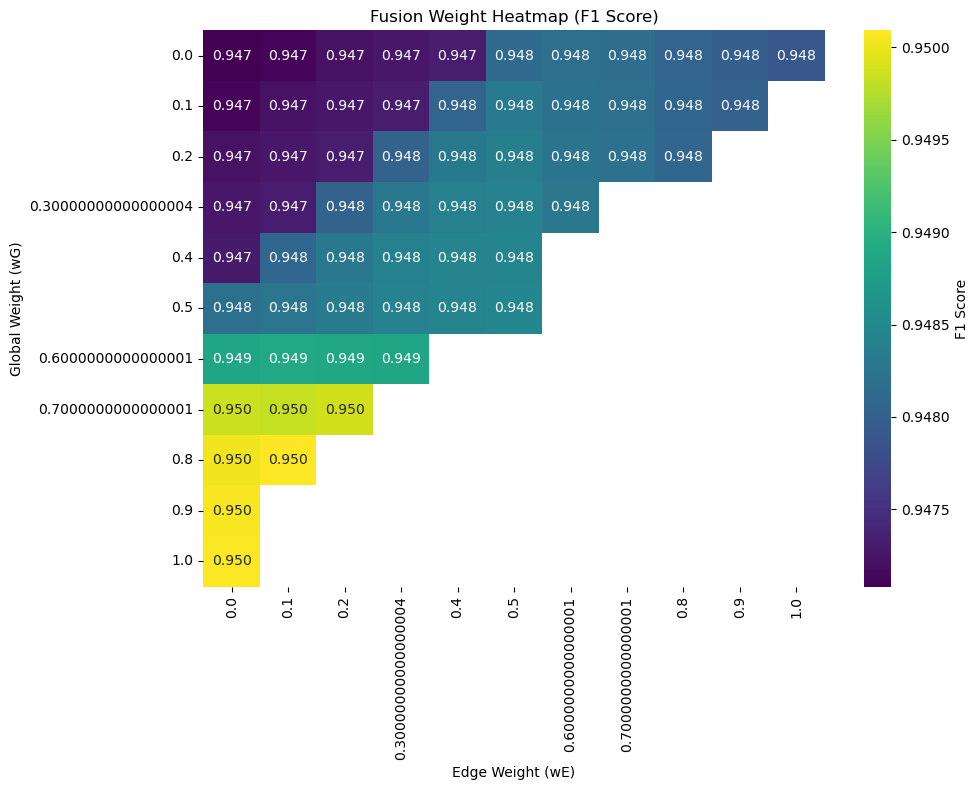

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Load your dataset
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df = pd.read_csv(csv_path)

# Prepare confidence arrays
G = df["Global_Conf"].values
E = df["Edge_Conf"].values
D = df["Device_Conf"].values
y_true = df["True_Label"].values

# Store results
results = []

# Try combinations of weights that sum to 1
weight_range = np.linspace(0, 1, 11)
for wg in weight_range:
    for we in weight_range:
        wd = 1 - wg - we
        if wd < 0 or wd > 1:
            continue
        
        fused = wg * G + we * E + wd * D
        fused_label = (fused > 0.5).astype(int)
        f1 = f1_score(y_true, fused_label)
        results.append({"wG": wg, "wE": we, "wD": wd, "F1": f1})

# Convert to DataFrame
df_grid = pd.DataFrame(results)

# Pivot table for heatmap (Global vs Edge, color = F1)
pivot = df_grid.pivot(index="wG", columns="wE", values="F1")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f", cbar_kws={"label": "F1 Score"})
plt.title("Fusion Weight Heatmap (F1 Score)")
plt.xlabel("Edge Weight (wE)")
plt.ylabel("Global Weight (wG)")
plt.tight_layout()
plt.show()

Best Threshold: 0.2527
Best F1 Score:  0.9496


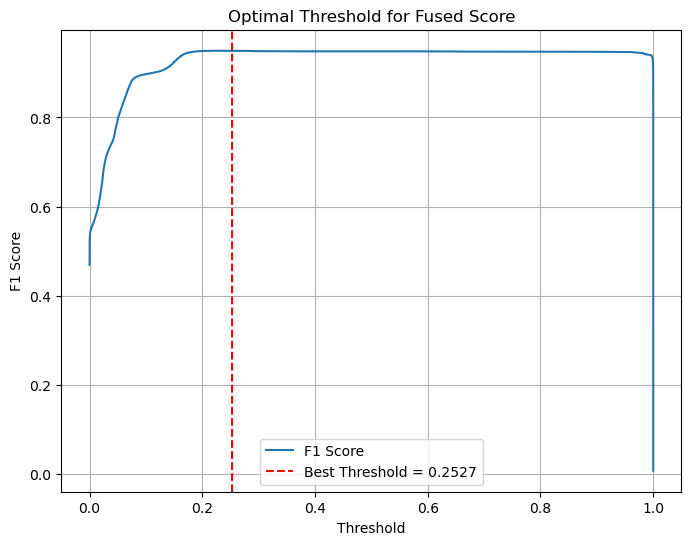

In [35]:
from sklearn.metrics import precision_recall_curve

# Use final fused score from current weights
fused_score = df["Fused_Score"].values

# Get precision-recall-thresholds
precision, recall, thresholds = precision_recall_curve(y_true, fused_score)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score:  {f1_scores[best_idx]:.4f}")

# Optional: Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")
plt.title("Optimal Threshold for Fused Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

Dataset loaded successfully. Shape: (2270317, 88)


Loading Global model...
Loading Edge model...
Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 172us/step
Core Layer (Fused) Accuracy: 0.9694

Core Layer Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573661
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270313
   macro avg       0.98      0.95      0.96   2270313
weighted avg       0.97      0.97      0.97   2270313



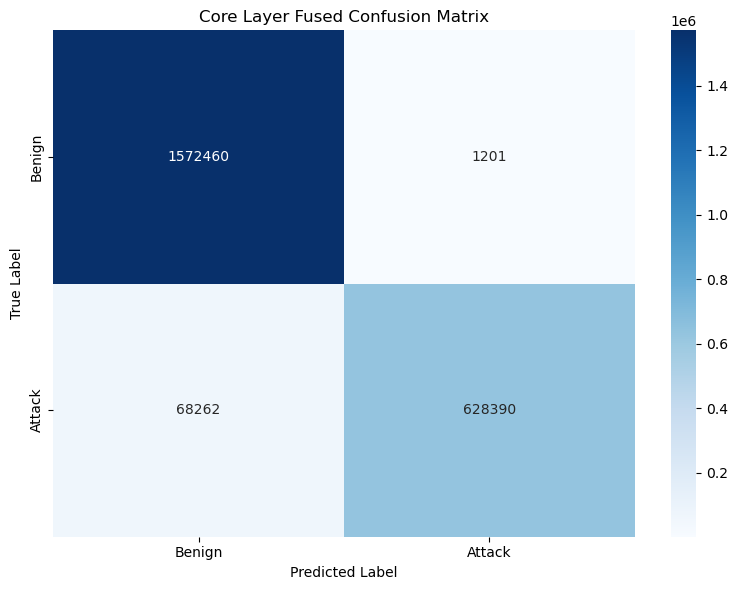

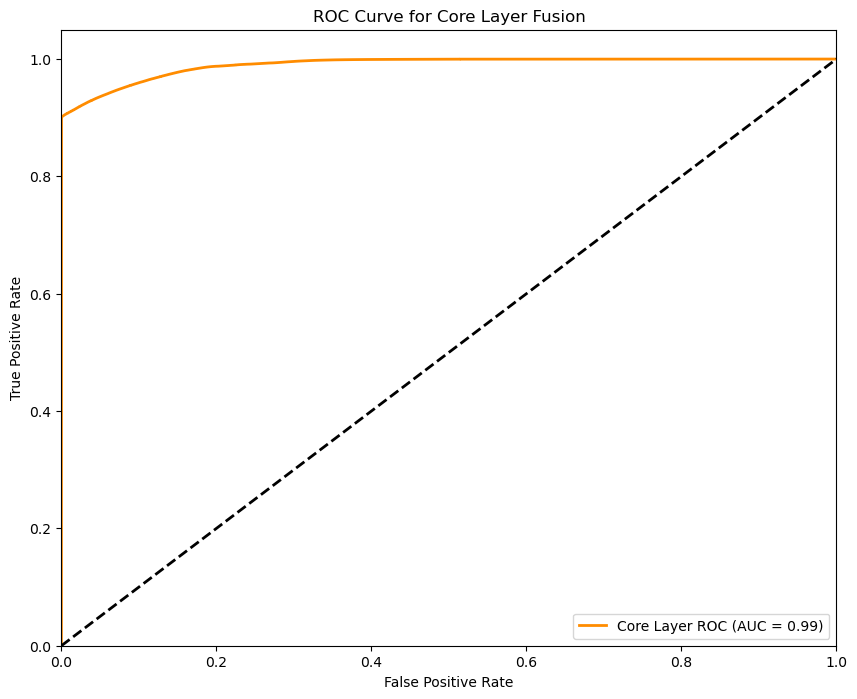


Core layer results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv


In [61]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 0: Setup and Paths
# -------------------------------
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

OUTPUT_CSV = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
RESULTS_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final"

DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# Step 1: Load the Dataset and Preprocess
# -------------------------------
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For simplicity we assume that the same CSV is used for all layers.
# Global layer uses a different set of features from Edge and Device.
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
# For Edge and Device layers we use their own features:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd Pkts/s", "Bwd Pkts/s", "Fwd IAT Mean"
]
device_features = [
    "Dst Port", "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Pkt Len Var",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std", "Flow Duration",
    "Flow IAT Mean", "Flow IAT Std", "Idle Max", "Idle Mean",
    "Active Min", "Active Max", "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len", "Pkt Size Avg",
    "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Hour_sin", "Hour_cos"
]

# For all layers we create a scaler from the full dataset (or use saved ones)
scaler = StandardScaler()
# For global features:
X_global = scaler.fit_transform(df[global_features])
# For edge features:
X_edge = scaler.fit_transform(df[edge_features])
# For device features:
X_device = scaler.fit_transform(df[device_features])
# Save the scaler if desired (here we save the device scaler as an example)
joblib.dump(scaler, os.path.join(RESULTS_DIR, "device_scaler.pkl"))

# Also, we need the true labels – we use binary labels (0: benign, 1: attack) 
df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)
y_binary = df["Binary_Label"].values

# -------------------------------
# Step 2: Load the Pre-Trained Models
# -------------------------------
# Global Layer: XGBoost model
print("Loading Global model...")
xgb_model = joblib.load(GLOBAL_MODEL_PATH)

# Edge Layer: LSTM model
print("Loading Edge model...")
edge_model = load_model(EDGE_MODEL_PATH)

# Device Layer: MLP model
print("Loading Device model...")
device_model = load_model(DEVICE_MODEL_PATH)

# -------------------------------
# Step 3: Run Predictions for Each Layer
# -------------------------------

# Global Layer Predictions
# (Global features X_global; note that X_global shape is (num_samples, len(global_features)))
y_pred_global = xgb_model.predict(X_global)
y_prob_global = xgb_model.predict_proba(X_global)
global_confidence = np.max(y_prob_global, axis=1)  # highest class probability

# Edge Layer Predictions
# For the Edge layer we need to build sequences. We assume a sliding window approach with sequence_length_edge=5.
sequence_length_edge = 5
num_edge_samples = X_edge.shape[0] - sequence_length_edge + 1
# Build sequences for the edge model:
X_edge_seq = np.array([X_edge[i:i+sequence_length_edge] for i in range(num_edge_samples)])
# Run predictions on the edge sequences (the model outputs per-time-step softmax probabilities)
edge_pred_prob_all = edge_model.predict(X_edge_seq, batch_size=64)  # shape: (num_edge_seq, sequence_length_edge, num_classes)
# For confidence fusion we use the “avg benign probability” method (assuming class 0 is benign).
avg_benign_prob = edge_pred_prob_all[:, 0] # average benign probability per sequence
edge_confidence = 1.0 - avg_benign_prob  # higher means more anomalous
# For final fusion, we trim to the minimum number of samples across layers
num_edge = len(edge_confidence)

# Device Layer Predictions
# Device layer uses the scaled device features (X_device)
y_pred_device_prob = device_model.predict(X_device, batch_size=64).flatten()  # probability of attack
device_confidence = y_pred_device_prob  # Already a probability (closer to 1 = attack)

# -------------------------------
# Step 4: Align the Predictions
# -------------------------------
# Our three models might have different numbers of predictions because of sequence-building.
# Here we align by taking the minimum number of predictions:
min_samples = min(len(global_confidence), num_edge, len(device_confidence))
global_confidence = global_confidence[:min_samples]
edge_confidence = edge_confidence[:min_samples]
device_confidence = device_confidence[:min_samples]
# Also, assume ground-truth binary labels (starting at the appropriate index)
true_labels = y_binary[:min_samples]

# -------------------------------
# Step 5: Fuse the Confidence Scores at the Core Layer
# -------------------------------
# We use confidence-weighted fusion. (Weights can be tuned.)
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_confidence = w_global * global_confidence + w_edge * edge_confidence + w_device * device_confidence
# Final binary prediction using a threshold (default 0.5; tune if necessary)
final_predictions = (fused_confidence > 0.5).astype(int)

# -------------------------------
# Step 6: Evaluate the Fused Predictions
# -------------------------------
final_acc = accuracy_score(true_labels, final_predictions)
print(f"Core Layer (Fused) Accuracy: {final_acc:.4f}")

print("\nCore Layer Classification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Benign", "Attack"]))

cm_fused = confusion_matrix(true_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fused, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.title("Core Layer Fused Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "core_layer_confusion_matrix.png"))
plt.show()

# ROC Curve for fused predictions
true_labels_bin = label_binarize(true_labels, classes=[0, 1]).ravel()
fpr_fused, tpr_fused, _ = roc_curve(true_labels_bin, fused_confidence)
roc_auc_fused = auc(fpr_fused, tpr_fused)
plt.figure(figsize=(10, 8))
plt.plot(fpr_fused, tpr_fused, color='darkorange', lw=2, label=f'Core Layer ROC (AUC = {roc_auc_fused:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Core Layer Fusion")
plt.legend(loc="lower right")
plt.savefig(os.path.join(RESULTS_DIR, "core_layer_roc.png"))
plt.show()

# -------------------------------
# Step 7: Save the Final Results to an Excel (CSV) Sheet
# -------------------------------
results_df = pd.DataFrame({
    "True_Label": true_labels,
    "Global_Confidence": global_confidence,
    "Edge_Confidence": edge_confidence,
    "Device_Confidence": device_confidence,
    "Fused_Confidence": fused_confidence,
    "Final_Prediction": final_predictions
})
results_df.to_csv(OUTPUT_CSV, index=False)
print(f"\nCore layer results saved to: {OUTPUT_CSV}")

In [63]:
import pandas as pd

# Load original dataset with attack types
df_full = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv")

# Load the previously saved core layer results
results_df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Ensure alignment: trim to same number of rows
results_df = results_df.iloc[:len(df_full)].copy()

# Add back the Original_Label column
results_df["Original_Label"] = df_full["Label"][:len(results_df)]

Original dataset loaded. Shape: (2270317, 88)
Core layer results loaded. Shape: (2270313, 6)
Attack-wise detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3835568600.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_summary = attack_only_df.groupby("Original_Label").apply(
/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3835568600.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")


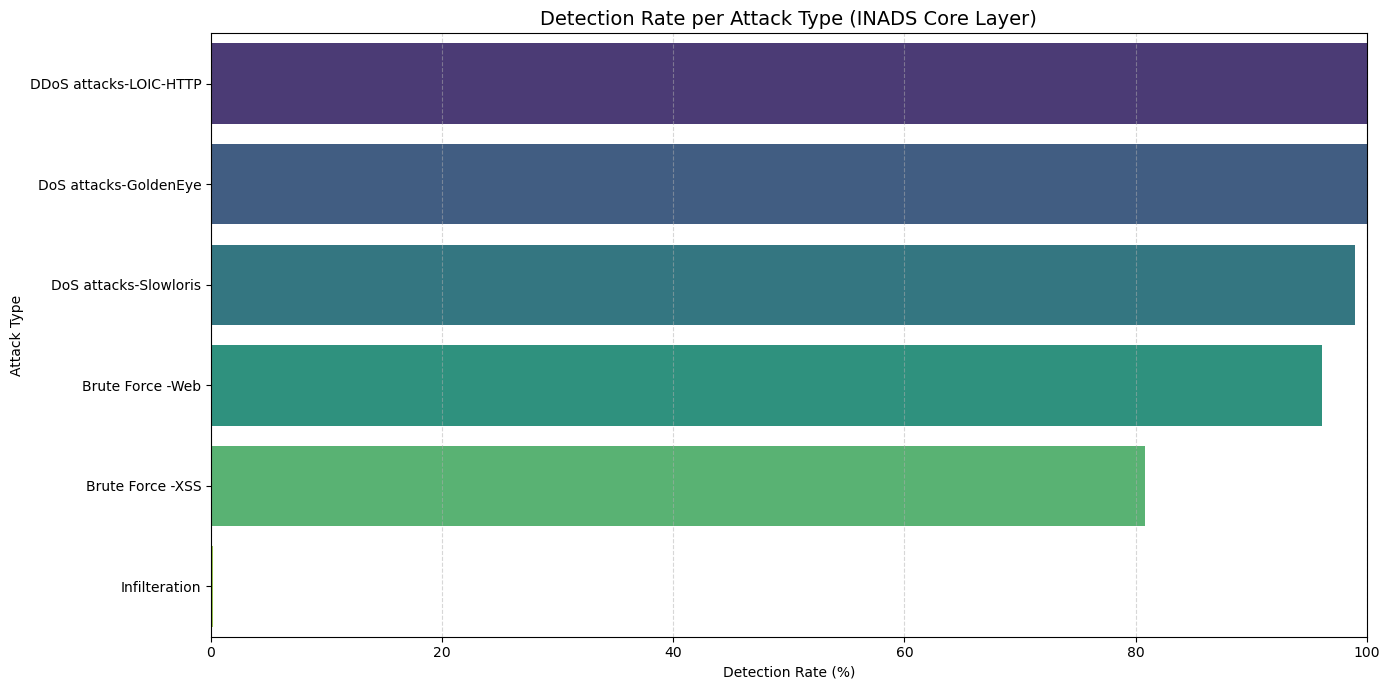


Core Layer Global Metrics:
Accuracy:  0.9694
Precision: 0.9981
Recall:    0.9020
F1 Score:  0.9476
ROC AUC:   0.9900


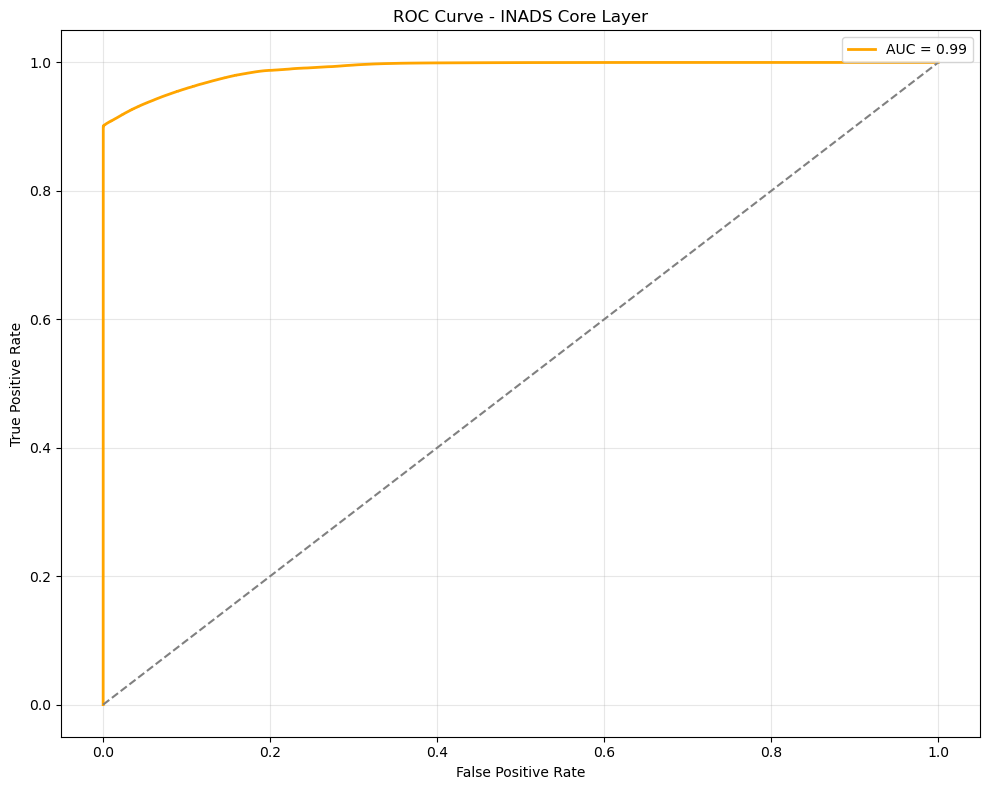

In [73]:
# %% [Markdown]
# ## INADS - Attack-Wise Detection Evaluation (Core Layer)

# %% [Code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score
)

# Paths
DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
RESULTS_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
ATTACK_EVAL_CSV = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv"

# %% [Code]
# Step 1: Load the full original dataset (with multi-class attack types)
df_full = pd.read_csv(DATA_PATH)
print("Original dataset loaded. Shape:", df_full.shape)

# Load core layer results
results_df = pd.read_csv(RESULTS_PATH)
print("Core layer results loaded. Shape:", results_df.shape)

# Ensure alignment (just in case)
results_df = results_df.iloc[:len(df_full)].copy()

# Step 2: Add back original attack type
results_df["Original_Label"] = df_full["Label"][:len(results_df)]

# %% [Code]
# Step 3: Filter only attack rows (True_Label == 1)
attack_only_df = results_df[results_df["True_Label"] == 1].copy()

# Step 4: Group by attack type and compute per-type detection metrics
attack_summary = attack_only_df.groupby("Original_Label").apply(
    lambda x: pd.Series({
        "Total Samples": len(x),
        "Detected (TP)": ((x["Final_Prediction"] == 1) & (x["True_Label"] == 1)).sum(),
        "Missed (FN)": ((x["Final_Prediction"] == 0) & (x["True_Label"] == 1)).sum(),
        "Precision": precision_score(x["True_Label"], x["Final_Prediction"]),
        "Recall": recall_score(x["True_Label"], x["Final_Prediction"]),
        "F1-Score": f1_score(x["True_Label"], x["Final_Prediction"]),
        "Detection Rate (%)": 100 * ((x["Final_Prediction"] == 1).sum()) / len(x)
    })
).sort_values("Detection Rate (%)", ascending=False)

# %% [Code]
# Step 5: Save summary
attack_summary.to_csv(ATTACK_EVAL_CSV)
print(f"Attack-wise detection summary saved to:\n{ATTACK_EVAL_CSV}")

# Display summary (top 10)
attack_summary.head(10)

# %% [Code]
# Step 6: Optional – Visualize Detection Rate per Attack Type
plt.figure(figsize=(14, 7))
sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate per Attack Type (INADS Core Layer)", fontsize=14)
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# %% [Code]
# Step 7: Global Statistics
overall_accuracy = accuracy_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_precision = precision_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_recall = recall_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_f1 = f1_score(results_df["True_Label"], results_df["Final_Prediction"])
roc_auc = roc_auc_score(results_df["True_Label"], results_df["Fused_Confidence"])

print("\nCore Layer Global Metrics:")
print(f"Accuracy:  {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall:    {overall_recall:.4f}")
print(f"F1 Score:  {overall_f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# %% [Code]
# Step 8: ROC Curve
fpr, tpr, _ = roc_curve(results_df["True_Label"], results_df["Fused_Confidence"])
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="orange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - INADS Core Layer")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Core layer results loaded: (2270313, 6)
Original dataset loaded: (2270317, 88)

Number of False Negatives for infilteration: 68108


,True_Label,Global_Confidence,Edge_Confidence,Device_Confidence,Fused_Confidence,Final_Prediction,Original_Label
377961,1,0.999903,0.028624,0.119560,0.356382,0,Infilteration
377966,1,0.999903,0.056609,0.119560,0.364778,0,Infilteration
377967,1,0.999903,0.050255,0.119564,0.362873,0,Infilteration
377968,1,0.999903,0.039487,0.119556,0.359639,0,Infilteration
377969,1,0.999903,0.033785,0.119563,0.357932,0,Infilteration


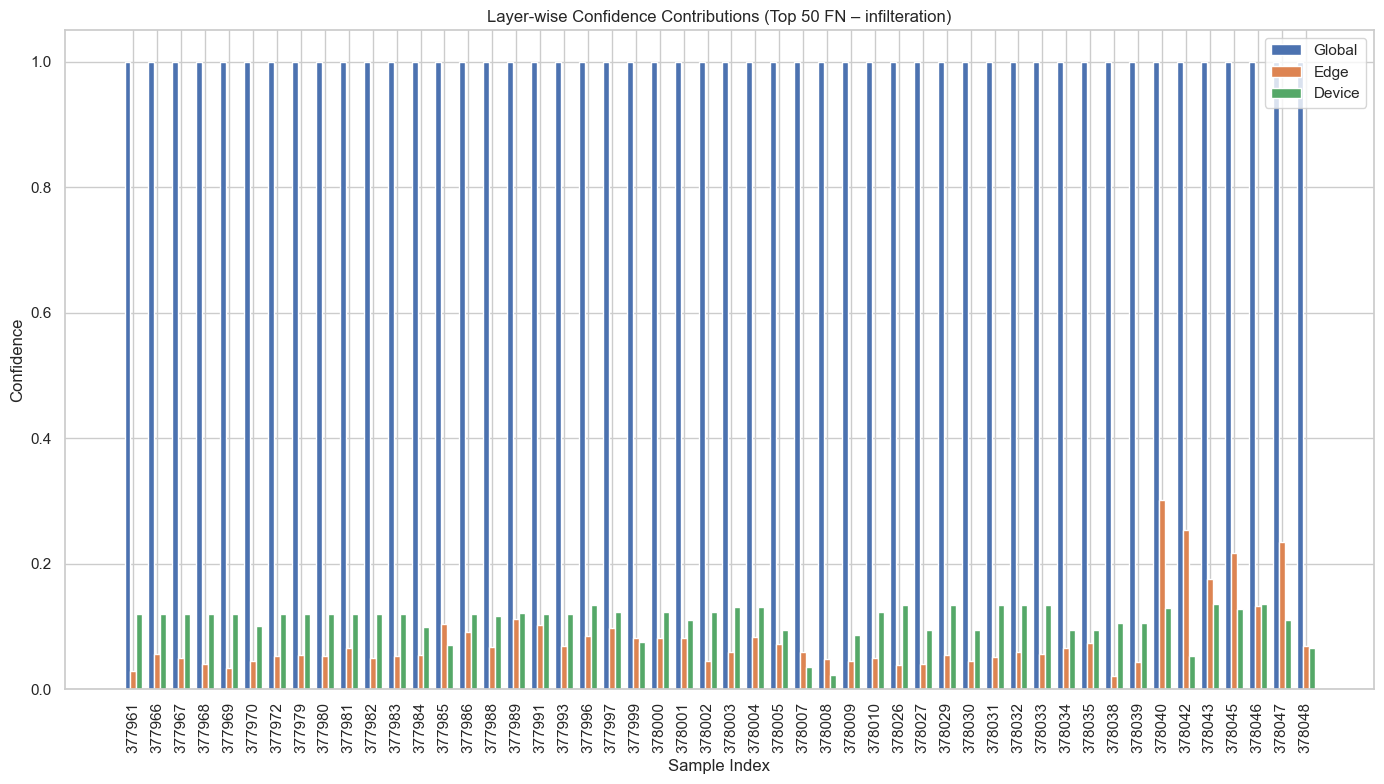


📁 TP, FP, FN summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3252044540.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_summary = results_df.groupby("Original_Label").apply(compute_tp_fp_fn)
/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3252044540.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")


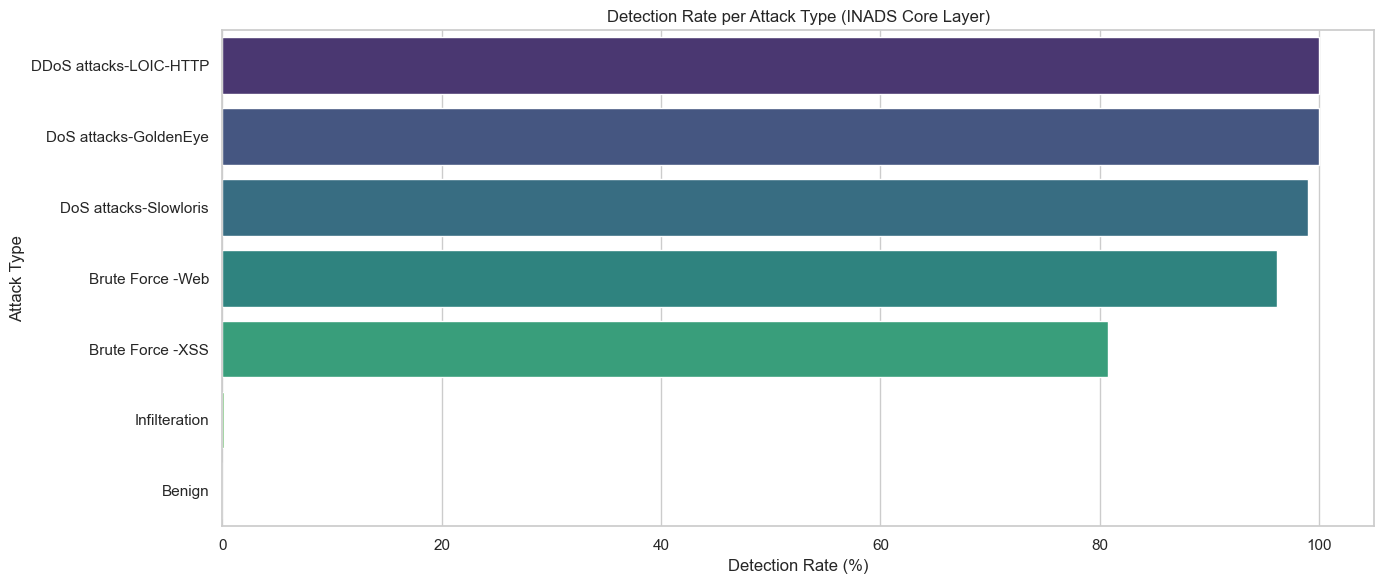

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 1: Load Files
# ------------------------------
results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv"
original_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# Load core layer predictions
results_df = pd.read_csv(results_path)
print("Core layer results loaded:", results_df.shape)

# Load original dataset to get Original_Label
df_original = pd.read_csv(original_data_path)
print("Original dataset loaded:", df_original.shape)

# Merge Original_Label into results_df
results_df["Original_Label"] = df_original["Label"][:len(results_df)]

# ------------------------------
# Step 2: Trace False Negatives – infilteration
# ------------------------------
infilteration_fns = results_df[
    (results_df["Original_Label"] == "Infilteration") &
    (results_df["True_Label"] == 1) &
    (results_df["Final_Prediction"] == 0)
]

print(f"\nNumber of False Negatives for infilteration: {len(infilteration_fns)}")
display(infilteration_fns.head())

# ------------------------------
# Step 3: Visualize Confidence Scores for FN – Optional (Top 50)
# ------------------------------
sampled_fns = infilteration_fns.head(50)  # pick top 50 for visualization

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
x = np.arange(len(sampled_fns))

ax.bar(x - bar_width, sampled_fns["Global_Confidence"], width=bar_width, label="Global")
ax.bar(x, sampled_fns["Edge_Confidence"], width=bar_width, label="Edge")
ax.bar(x + bar_width, sampled_fns["Device_Confidence"], width=bar_width, label="Device")

ax.set_xticks(x)
ax.set_xticklabels(sampled_fns.index, rotation=90)
ax.set_title("Layer-wise Confidence Contributions (Top 50 FN – infilteration)")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Confidence")
ax.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# Step 4: TP, FP, FN per Attack Type
# ------------------------------
def compute_tp_fp_fn(group):
    tp = ((group["True_Label"] == 1) & (group["Final_Prediction"] == 1)).sum()
    fn = ((group["True_Label"] == 1) & (group["Final_Prediction"] == 0)).sum()
    fp = ((group["True_Label"] == 0) & (group["Final_Prediction"] == 1)).sum()
    return pd.Series({
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "Total Attacks": tp + fn,
        "Detection Rate (%)": (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    })

attack_summary = results_df.groupby("Original_Label").apply(compute_tp_fp_fn)
attack_summary = attack_summary.sort_values("Detection Rate (%)", ascending=False)

# Save detailed summary
attack_summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
attack_summary.to_csv(attack_summary_path)
print(f"\nTP, FP, FN summary saved to: {attack_summary_path}")

# ------------------------------
# Step 5: Visualize Detection Rate
# ------------------------------
plt.figure(figsize=(14, 6))
sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate per Attack Type (INADS Core Layer)")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Load the TP/FP/FN summary
# -------------------------------
tp_fp_fn_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(tp_fp_fn_path)
print("Loaded summary:", df.shape)

# -------------------------------
# Compute Derived Metrics
# -------------------------------
df["Total_Attacks"] = df["TP"] + df["FN"]
df["Detection_Rate(%)"] = round(100 * df["TP"] / df["Total_Attacks"], 2)
df["False_Positive_Rate(%)"] = round(100 * df["FP"] / (df["TP"] + df["FP"]), 2)

# Optional: F1 Score
df["Precision"] = df["TP"] / (df["TP"] + df["FP"] + 1e-6)
df["Recall"] = df["TP"] / (df["TP"] + df["FN"] + 1e-6)
df["F1_Score"] = round(2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"] + 1e-6), 4)

# -------------------------------
# Save Enhanced Table
# -------------------------------
out_csv = tp_fp_fn_path.replace(".csv", "_enhanced.csv")
df.to_csv(out_csv, index=False)
print(f"Enhanced TP/FP/FN summary saved to: {out_csv}")

Loaded summary: (7, 6)
Enhanced TP/FP/FN summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv


<Figure size 1400x600 with 0 Axes>

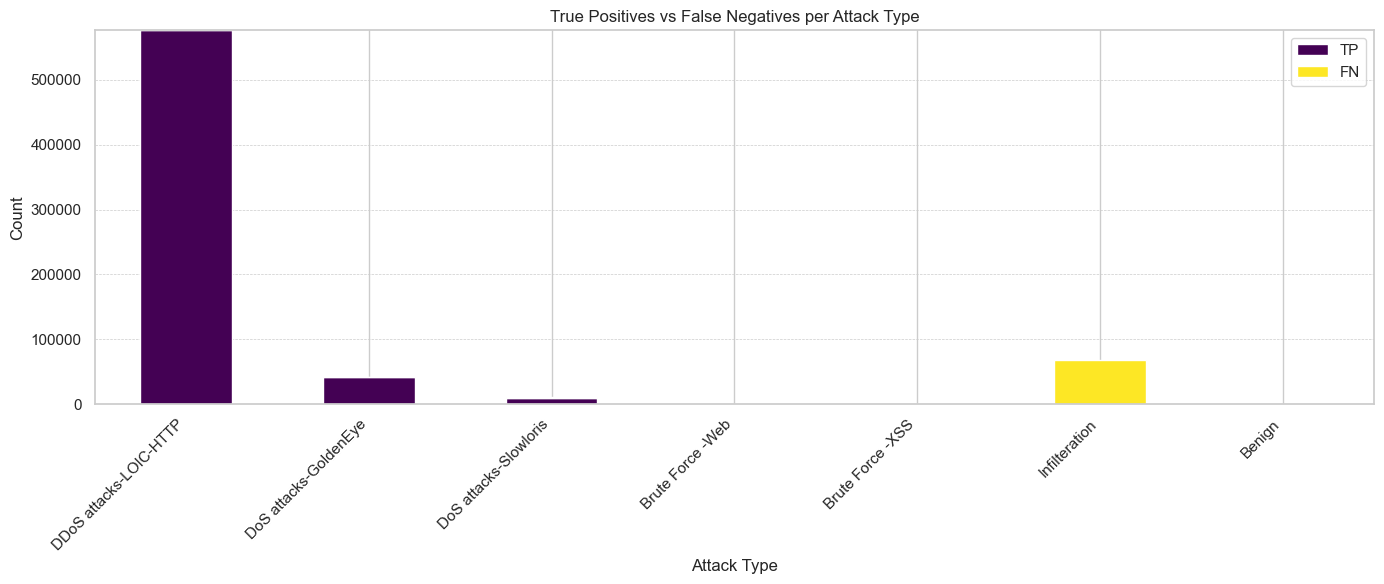

In [103]:
# Plot TP vs FN (per attack type)
plt.figure(figsize=(14, 6))
df_plot = df.sort_values("Detection_Rate(%)", ascending=False)
df_plot.set_index("Original_Label")[["TP", "FN"]].plot(kind="bar", stacked=True, figsize=(14,6), colormap="viridis")
plt.title("True Positives vs False Negatives per Attack Type")
plt.ylabel("Count")
plt.xlabel("Attack Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

Summary loaded: (7, 6)
Enhanced summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3231600650.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sort_values("Detection_Rate(%)", ascending=False),


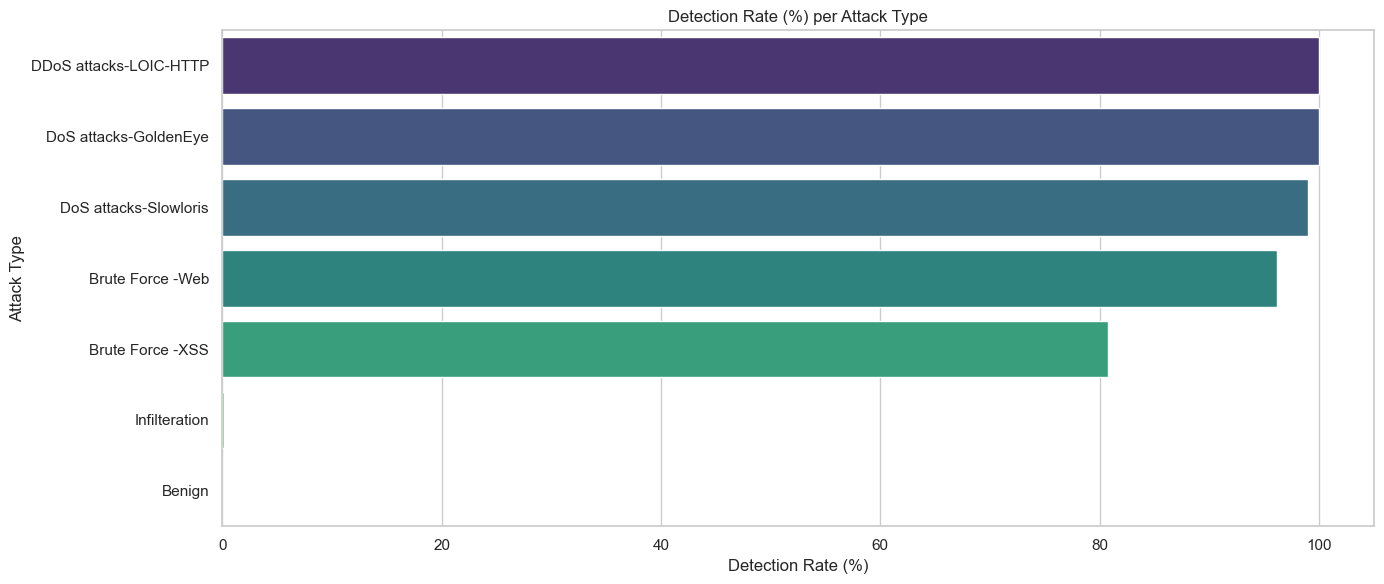

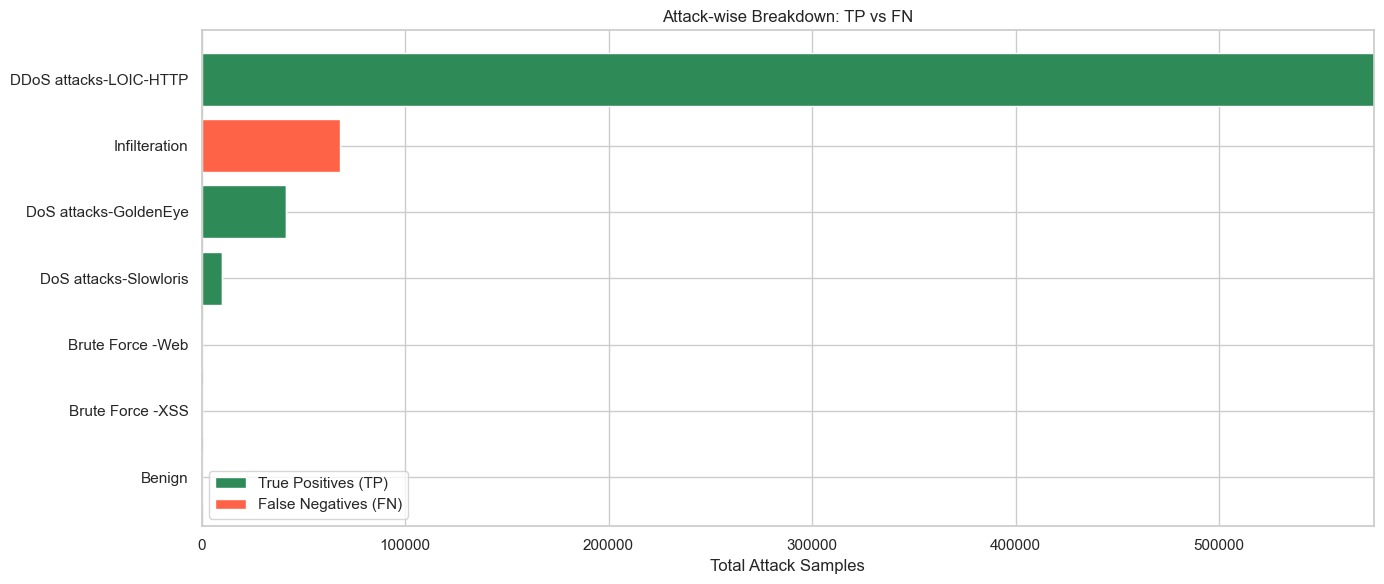

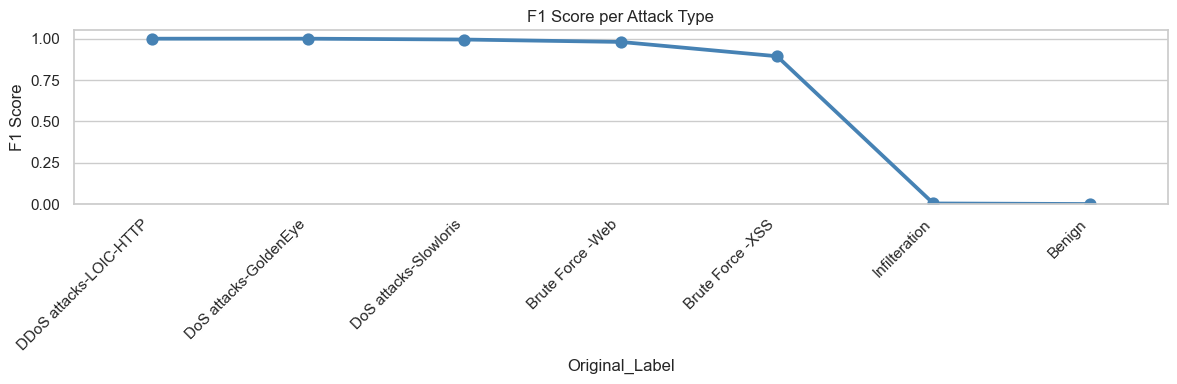

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# -------------------------------
# Load existing TP/FP/FN summary
# -------------------------------
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(summary_path)
print("Summary loaded:", df.shape)

# -------------------------------
# Derive Key Metrics
# -------------------------------
df["Total_Attacks"] = df["TP"] + df["FN"]
df["Detection_Rate(%)"] = round(100 * df["TP"] / df["Total_Attacks"], 2)
df["False_Positive_Rate(%)"] = round(100 * df["FP"] / (df["TP"] + df["FP"] + 1e-6), 2)

# Optional: F1 Score
df["Precision"] = df["TP"] / (df["TP"] + df["FP"] + 1e-6)
df["Recall"] = df["TP"] / (df["TP"] + df["FN"] + 1e-6)
df["F1_Score"] = round(2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"] + 1e-6), 4)

# Save enhanced version
enhanced_path = summary_path.replace(".csv", "_enhanced.csv")
df.to_csv(enhanced_path, index=False)
print(f"Enhanced summary saved to: {enhanced_path}")

# -------------------------------
# Barplot: Detection Rate (%)
# -------------------------------
plt.figure(figsize=(14, 6))
sns.barplot(data=df.sort_values("Detection_Rate(%)", ascending=False),
            x="Detection_Rate(%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate (%) per Attack Type")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.xlim(0, 105)
plt.tight_layout()
plt.show()

# -------------------------------
# Stacked Bar: TP vs FN
# -------------------------------
df_stacked = df.sort_values("Total_Attacks", ascending=False)
plt.figure(figsize=(14, 6))
plt.barh(df_stacked["Original_Label"], df_stacked["TP"], color="seagreen", label="True Positives (TP)")
plt.barh(df_stacked["Original_Label"], df_stacked["FN"], left=df_stacked["TP"], color="tomato", label="False Negatives (FN)")
plt.xlabel("Total Attack Samples")
plt.title("Attack-wise Breakdown: TP vs FN")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -------------------------------
# Plot: F1 Score
# -------------------------------
plt.figure(figsize=(12, 4))
sns.pointplot(data=df.sort_values("F1_Score", ascending=False),
              x="Original_Label", y="F1_Score", color="steelblue", marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("F1 Score per Attack Type")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.05)
plt.tight_layout()
plt.show()


Enhanced summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv

INADS Core Layer – Attack Detection Summary:



,Original_Label,Total_Attacks,TP,FN,FP,Detection_Rate(%),Precision,Recall,F1_Score,False_Positive_Rate(%)
0,DDoS attacks-LOIC-HTTP,576175.0,576171.0,4.0,0.0,99.999306,1.0,1.0000,1.0000,0.0
1,DoS attacks-GoldenEye,41455.0,41453.0,2.0,0.0,99.995175,1.0,1.0000,1.0000,0.0
2,DoS attacks-Slowloris,10285.0,10180.0,105.0,0.0,98.979096,1.0,0.9898,0.9949,0.0
3,Brute Force -Web,362.0,348.0,14.0,0.0,96.132597,1.0,0.9613,0.9803,0.0
4,Brute Force -XSS,151.0,122.0,29.0,0.0,80.794702,1.0,0.8079,0.8937,0.0
5,Infilteration,68224.0,116.0,68108.0,0.0,0.170028,1.0,0.0017,0.0034,0.0
6,Benign,0.0,0.0,0.0,1201.0,0.000000,0.0,NaN,NaN,100.0


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1944579011.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


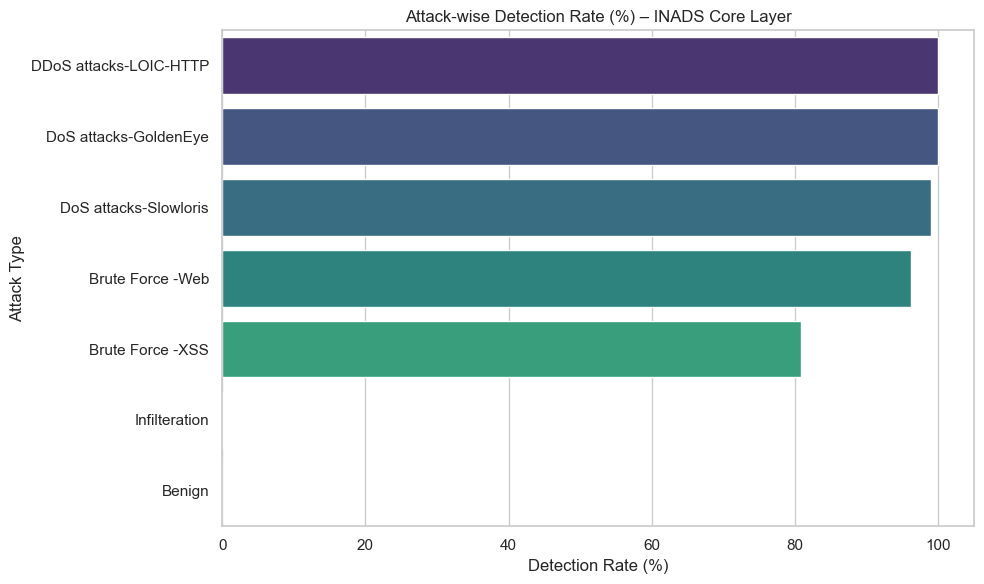

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load base summary
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(summary_path)

# Rename columns to avoid space-based duplicates
df.rename(columns={
    "Total Attacks": "Total_Attacks",
    "Detection Rate (%)": "Detection_Rate(%)"
}, inplace=True)

# Compute additional metrics safely
df["Precision"] = (df["TP"] / (df["TP"] + df["FP"])).round(4)
df["Recall"] = (df["TP"] / (df["TP"] + df["FN"])).round(4)
df["F1_Score"] = (2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])).round(4)
df["False_Positive_Rate(%)"] = ((df["FP"] / (df["TP"] + df["FP"])) * 100).round(2)

# Save enhanced version
enhanced_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv"
df.to_csv(enhanced_path, index=False)
print(f"\nEnhanced summary saved to: {enhanced_path}")

# Display selected metrics
print("\nINADS Core Layer – Attack Detection Summary:\n")
display(df[[
    "Original_Label", "Total_Attacks", "TP", "FN", "FP", "Detection_Rate(%)",
    "Precision", "Recall", "F1_Score", "False_Positive_Rate(%)"
]])

# Optional: Horizontal barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.sort_values("Detection_Rate(%)", ascending=False),
    x="Detection_Rate(%)", y="Original_Label", palette="viridis"
)
plt.title("Attack-wise Detection Rate (%) – INADS Core Layer")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.savefig("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attackwise_barplot.png")
plt.show()

In [95]:
print(results_df["Original_Label"].unique())

['Benign' 'Infilteration' 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris'
 'DDoS attacks-LOIC-HTTP' 'Brute Force -Web' 'Brute Force -XSS']


In [117]:
import pandas as pd

# -------------------------------
# Step 1: Load predictions and raw labels
# -------------------------------
results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
raw_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

df = pd.read_csv(results_path)
df_raw = pd.read_csv(raw_data_path)

# Attach original attack labels to results
df["Original_Label"] = df_raw["Label"][:len(df)]

# Add binary labels if missing
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = (df["True_Label"] == 1).astype(int)

# -------------------------------
# Step 2: Filter only attack samples for analysis
# -------------------------------
attack_df = df[df["Binary_Label"] == 1]

# -------------------------------
# Step 3: Define metric calculation function
# -------------------------------
def compute_metrics(group, pred_col):
    attack_total = len(group)
    tp = ((group["True_Label"] == 1) & (group[pred_col] == 1)).sum()
    fn = ((group["True_Label"] == 1) & (group[pred_col] == 0)).sum()
    detection_rate = 100 * tp / attack_total if attack_total > 0 else 0
    return pd.Series({
        f"{pred_col}_TP": tp,
        f"{pred_col}_FN": fn,
        f"{pred_col}_Detection(%)": round(detection_rate, 2)
    })

# -------------------------------
# Step 4: Run for each layer's predictions
# -------------------------------
layer_metrics = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([
    compute_metrics(g, "Final_Prediction"),
    compute_metrics(g, "Global_Confidence" if "Global_Prediction" not in g else "Global_Prediction"),
    compute_metrics(g, "Edge_Confidence" if "Edge_Prediction" not in g else "Edge_Prediction"),
    compute_metrics(g, "Device_Confidence" if "Device_Prediction" not in g else "Device_Prediction")
], axis=0))

# Optional: clean up the index
layer_metrics.reset_index(inplace=True)

# -------------------------------
# Step 5: Save and show
# -------------------------------
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"
layer_metrics.to_csv(output_path, index=False)

print(f"\nPer-attack detection summary saved to:\n{output_path}")
display(layer_metrics)


Per-attack detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/2645590937.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_metrics = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([


,Original_Label,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Confidence_TP,Global_Confidence_FN,Global_Confidence_Detection(%),Edge_Confidence_TP,Edge_Confidence_FN,Edge_Confidence_Detection(%),Device_Confidence_TP,Device_Confidence_FN,Device_Confidence_Detection(%)
0,Brute Force -Web,348.0,14.0,96.13,0.0,0.0,0.0,164.0,0.0,45.30,0.0,0.0,0.00
1,Brute Force -XSS,122.0,29.0,80.79,0.0,0.0,0.0,61.0,0.0,40.40,27.0,0.0,17.88
2,DDoS attacks-LOIC-HTTP,576171.0,4.0,100.00,0.0,0.0,0.0,444310.0,0.0,77.11,290001.0,0.0,50.33
3,DoS attacks-GoldenEye,41453.0,2.0,100.00,0.0,0.0,0.0,11333.0,0.0,27.34,27194.0,0.0,65.60
4,DoS attacks-Slowloris,10180.0,105.0,98.98,0.0,0.0,0.0,3176.0,0.0,30.88,0.0,0.0,0.00
5,Infilteration,116.0,68108.0,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.00


In [119]:
import pandas as pd

# Paths
core_results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
raw_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"

# Load predictions & raw labels
df = pd.read_csv(core_results_path)
df_raw = pd.read_csv(raw_data_path)

# Merge Original_Label
df["Original_Label"] = df_raw["Label"][:len(df)]

# Create Binary Ground Truth
df["Binary_Label"] = (df["Original_Label"] != "Benign").astype(int)

# Threshold each layer to get binary predictions
df["Global_Prediction"] = (df["Global_Confidence"] > 0.5).astype(int)
df["Edge_Prediction"] = (df["Edge_Confidence"] > 0.5).astype(int)
df["Device_Prediction"] = (df["Device_Confidence"] > 0.5).astype(int)

# Filter only attack rows
attack_df = df[df["Binary_Label"] == 1]

# Function to compute metrics per attack type
def compute_metrics(subdf, pred_col):
    total = len(subdf)
    tp = ((subdf[pred_col] == 1)).sum()
    fn = ((subdf[pred_col] == 0)).sum()
    detection = round((tp / total) * 100, 2) if total > 0 else 0.0
    return pd.Series({
        f"{pred_col}_TP": tp,
        f"{pred_col}_FN": fn,
        f"{pred_col}_Detection(%)": detection
    })

# Apply per-layer metrics by attack type
layer_metrics = attack_df.groupby("Original_Label").apply(
    lambda g: pd.concat([
        compute_metrics(g, "Final_Prediction"),
        compute_metrics(g, "Global_Prediction"),
        compute_metrics(g, "Edge_Prediction"),
        compute_metrics(g, "Device_Prediction"),
    ], axis=0)
).reset_index()

# Save and display
layer_metrics.to_csv(output_path, index=False)
print(f"\nPer-attack detection summary saved to:\n{output_path}")
display(layer_metrics)


Per-attack detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3971820372.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_metrics = attack_df.groupby("Original_Label").apply(


,Original_Label,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Prediction_TP,Global_Prediction_FN,Global_Prediction_Detection(%),Edge_Prediction_TP,Edge_Prediction_FN,Edge_Prediction_Detection(%),Device_Prediction_TP,Device_Prediction_FN,Device_Prediction_Detection(%)
0,Brute Force -Web,348.0,14.0,96.13,362.0,0.0,100.0,338.0,24.0,93.37,149.0,213.0,41.16
1,Brute Force -XSS,122.0,29.0,80.79,151.0,0.0,100.0,86.0,65.0,56.95,72.0,79.0,47.68
2,DDoS attacks-LOIC-HTTP,576171.0,4.0,100.00,576175.0,0.0,100.0,576095.0,80.0,99.99,575862.0,313.0,99.95
3,DoS attacks-GoldenEye,41453.0,2.0,100.00,41455.0,0.0,100.0,41424.0,31.0,99.93,41427.0,28.0,99.93
4,DoS attacks-Slowloris,10180.0,105.0,98.98,10285.0,0.0,100.0,10110.0,175.0,98.30,9710.0,575.0,94.41
5,Infilteration,116.0,68108.0,0.17,68224.0,0.0,100.0,19.0,68205.0,0.03,95.0,68129.0,0.14


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1331546114.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_core, plot_type="bar", show=False)


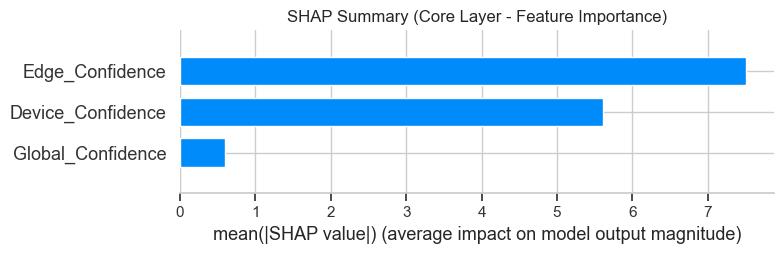

/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1331546114.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_core)


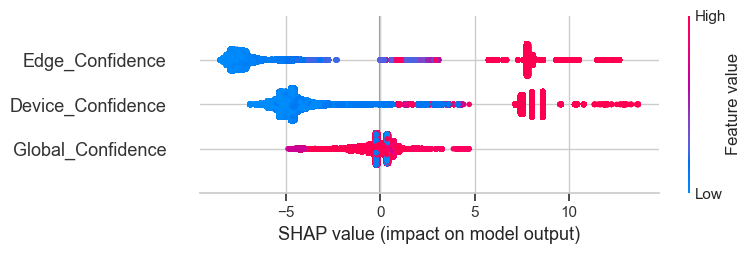

In [121]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Load your fused prediction results
core_df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Extract input features to the fusion model (these are the confidence scores from each layer)
X_core = core_df[["Global_Confidence", "Edge_Confidence", "Device_Confidence"]]
y_core = core_df["Final_Prediction"]

# Train a simple surrogate model for interpretability
surrogate = xgb.XGBClassifier(n_estimators=100, max_depth=3)
surrogate.fit(X_core, y_core)

# Use SHAP to explain predictions
explainer = shap.Explainer(surrogate)
shap_values = explainer(X_core)

# Plot global feature importance
shap.summary_plot(shap_values, X_core, plot_type="bar", show=False)
plt.title("SHAP Summary (Core Layer - Feature Importance)")
plt.tight_layout()
plt.savefig("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_shap_bar.png")
plt.show()

# Optional: Beeswarm for detailed view
shap.summary_plot(shap_values, X_core)

In [123]:
import pandas as pd
import numpy as np

# -------------------------------
# STEP 1: Load Core Prediction File
# -------------------------------
core_results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
df = pd.read_csv(core_results_path)

# -------------------------------
# STEP 2: Load True Labels & Attack Names
# -------------------------------
label_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
df_labels = pd.read_csv(label_path)
df["Original_Label"] = df_labels["Label"][:len(df)]  # align correctly

# Binarize true label (0 = benign, 1 = attack)
df["Binary_Label"] = np.where(df["Original_Label"].str.lower() == "benign", 0, 1)

# -------------------------------
# STEP 3: Convert Confidence Scores to Binary Predictions
# -------------------------------
threshold = 0.5  # tunable threshold

df["Global_Prediction"] = (df["Global_Confidence"] > threshold).astype(int)
df["Edge_Prediction"] = (df["Edge_Confidence"] > threshold).astype(int)
df["Device_Prediction"] = (df["Device_Confidence"] > threshold).astype(int)
df["Final_Prediction"] = (df["Fused_Confidence"] > threshold).astype(int)

# -------------------------------
# STEP 4: Per-Attack Metric Calculation Function
# -------------------------------
def compute_detection_metrics(group, pred_col):
    tp = ((group["Binary_Label"] == 1) & (group[pred_col] == 1)).sum()
    fn = ((group["Binary_Label"] == 1) & (group[pred_col] == 0)).sum()
    detection = round((tp / (tp + fn)) * 100, 2) if (tp + fn) > 0 else 0
    return pd.Series({f"{pred_col}_TP": tp, f"{pred_col}_FN": fn, f"{pred_col}_Detection(%)": detection})

# -------------------------------
# STEP 5: Group by Attack Type and Apply for Each Layer
# -------------------------------
attack_df = df[df["Binary_Label"] == 1]

layerwise_df = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([
    compute_detection_metrics(g, "Final_Prediction"),
    compute_detection_metrics(g, "Global_Prediction"),
    compute_detection_metrics(g, "Edge_Prediction"),
    compute_detection_metrics(g, "Device_Prediction"),
], axis=0)).reset_index()

# Add total attacks for context
attack_counts = attack_df["Original_Label"].value_counts().reset_index()
attack_counts.columns = ["Original_Label", "Total_Attacks"]
layerwise_df = attack_counts.merge(layerwise_df, on="Original_Label")

# -------------------------------
# STEP 6: Save the Results
# -------------------------------
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"
layerwise_df.to_csv(output_path, index=False)
print(f"Detection breakdown saved to:\n{output_path}")

# Optional Preview
display(layerwise_df)

Detection breakdown saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/2266664277.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layerwise_df = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([


,Original_Label,Total_Attacks,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Prediction_TP,Global_Prediction_FN,Global_Prediction_Detection(%),Edge_Prediction_TP,Edge_Prediction_FN,Edge_Prediction_Detection(%),Device_Prediction_TP,Device_Prediction_FN,Device_Prediction_Detection(%)
0,DDoS attacks-LOIC-HTTP,576175,576171.0,4.0,100.00,576175.0,0.0,100.0,576095.0,80.0,99.99,575862.0,313.0,99.95
1,Infilteration,68224,116.0,68108.0,0.17,68224.0,0.0,100.0,19.0,68205.0,0.03,95.0,68129.0,0.14
2,DoS attacks-GoldenEye,41455,41453.0,2.0,100.00,41455.0,0.0,100.0,41424.0,31.0,99.93,41427.0,28.0,99.93
3,DoS attacks-Slowloris,10285,10180.0,105.0,98.98,10285.0,0.0,100.0,10110.0,175.0,98.30,9710.0,575.0,94.41
4,Brute Force -Web,362,348.0,14.0,96.13,362.0,0.0,100.0,338.0,24.0,93.37,149.0,213.0,41.16
5,Brute Force -XSS,151,122.0,29.0,80.79,151.0,0.0,100.0,86.0,65.0,56.95,72.0,79.0,47.68


In [125]:
import pandas as pd

# Load full results
df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Load original labels
df_raw = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv")
df["Original_Label"] = df_raw["Label"][:len(df)].values
df["Binary_Label"] = (df["Original_Label"].str.lower() != "benign").astype(int)

# Let's inspect infiltration
infil_df = df[df["Original_Label"].str.lower() == "infilteration"]

# Ensure the predictions are present
if "Global_Prediction" not in df.columns:
    # Assuming threshold > 0.5 on confidence gives 1
    df["Global_Prediction"] = (df["Global_Confidence"] > 0.5).astype(int)
    infil_df = df[df["Original_Label"].str.lower() == "infilteration"]

# Now compute TP, FN
tp = ((infil_df["Binary_Label"] == 1) & (infil_df["Global_Prediction"] == 1)).sum()
fn = ((infil_df["Binary_Label"] == 1) & (infil_df["Global_Prediction"] == 0)).sum()

# Detection Rate
detection_rate = round(100 * tp / (tp + fn), 4) if (tp + fn) > 0 else 0

print(f"Infiltration Global Detection:\nTP = {tp}, FN = {fn}, Detection Rate = {detection_rate}%")

Infiltration Global Detection:
TP = 68224, FN = 0, Detection Rate = 100.0%


In [127]:
print("Number of unique rows used for training:", len(set(xgb_model.get_booster().get_dump())))
print("Number of rows in Global Confidence output:", len(df))

Number of unique rows used for training: 2100
Number of rows in Global Confidence output: 2270313


Loading dataset...
Dataset loaded successfully. Shape: (2270317, 90)
Loading Global model...
Loading Edge model...


Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 174us/step
Fused core layer accuracy: 0.9520

Fused Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97   1573665
      Attack       1.00      0.84      0.92    696652

    accuracy                           0.95   2270317
   macro avg       0.97      0.92      0.94   2270317
weighted avg       0.96      0.95      0.95   2270317


Fused Core Confusion Matrix:
[[1573663       2]
 [ 108941  587711]]


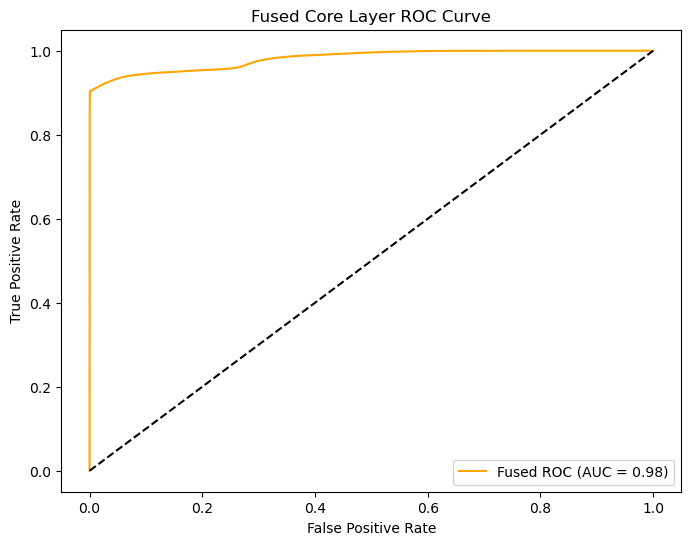


Core layer fusion results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv

Logistic Fusion Model F1 Score on Validation Set: 0.9474
Logistic Fusion Core Accuracy: 0.9690

Logistic Fusion Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573665
      Attack       0.99      0.91      0.95    696652

    accuracy                           0.97   2270317
   macro avg       0.98      0.95      0.96   2270317
weighted avg       0.97      0.97      0.97   2270317


Logistic Fusion Core Confusion Matrix:
[[1569167    4498]
 [  65911  630741]]

Best Threshold on Logistic Fusion: 0.7599999999999997


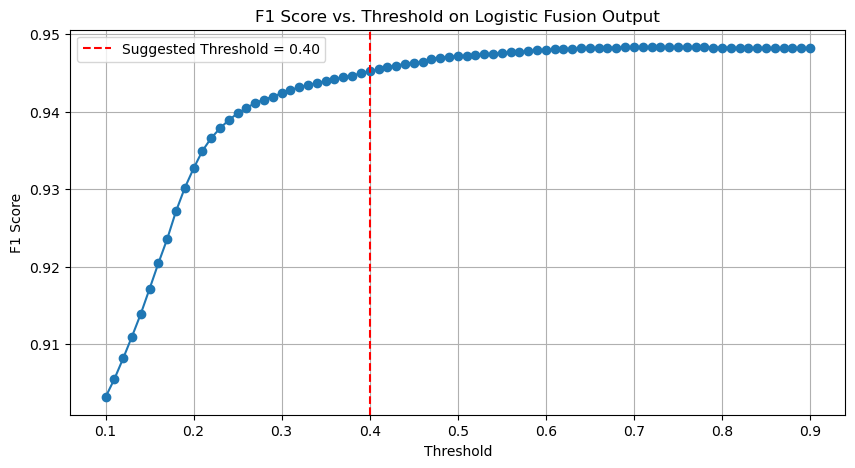

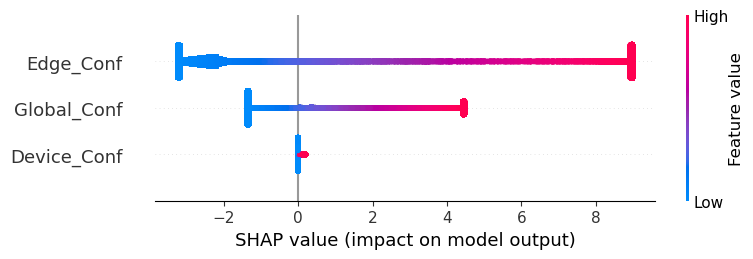

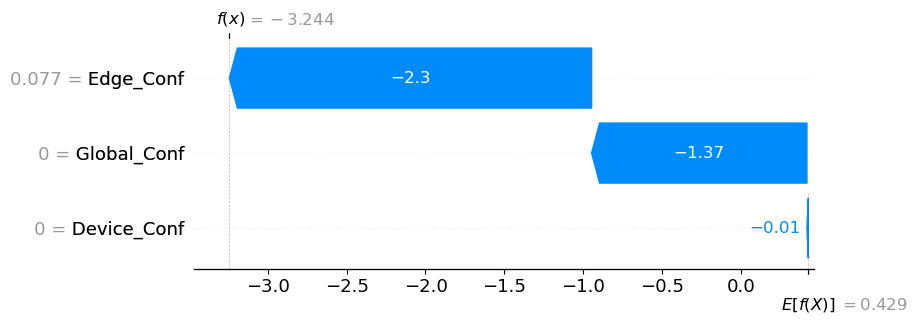


✅ CSE CIC IDS 2018 Fusion Evaluation Completed.


In [4]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import shap

# =================================================================
# Part 1: Setup and Load Data/Models (CIC IDS 2018)
# =================================================================
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH   = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)       # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)    # MLP

# =================================================================
# Part 2: Layer-wise Predictions and Fusion (Core Layer)
# =================================================================

# --- GLOBAL LAYER ---
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
X_global = df[global_features].values
y_pred_proba_global = xgb_global.predict_proba(X_global)
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# --- EDGE LAYER (LSTM) ---
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)
sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i : i+sequence_length] for i in range(num_samples_edge)])
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)
attack_conf_edge = 1.0 - edge_proba[:, 0]
attack_conf_edge_aligned = np.empty(X_edge.shape[0])
attack_conf_edge_aligned[:sequence_length-1] = np.nan
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# --- DEVICE LAYER (MLP) ---
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)
device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
attack_conf_device = device_proba

# ----------------------------------------------------------------
# Fusion
# ----------------------------------------------------------------
attack_conf_global = np.array(attack_conf_global)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)
attack_conf_device = np.array(attack_conf_device)

w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_score = (w_global * attack_conf_global +
               w_edge * attack_conf_edge_aligned +
               w_device * attack_conf_device)
fused_score = np.nan_to_num(fused_score, nan=0.0)
fused_label = (fused_score > 0.5).astype(int)

y_true = df["Binary_Label"].values
assert len(y_true) == len(fused_label), "Mismatch in lengths!"

acc_core = accuracy_score(y_true, fused_label)
print(f"Fused core layer accuracy: {acc_core:.4f}")

print("\nFused Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))

cm_core = confusion_matrix(y_true, fused_label)
print("\nFused Core Confusion Matrix:")
print(cm_core)

fpr_fused, tpr_fused, _ = roc_curve(y_true, fused_score)
roc_auc_fused = auc(fpr_fused, tpr_fused)
plt.figure(figsize=(8,6))
plt.plot(fpr_fused, tpr_fused, color='orange', label=f"Fused ROC (AUC = {roc_auc_fused:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fused Core Layer ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(CORE_LAYER_DIR, "core_layer_fused_roc.png"))
plt.show()

core_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf":   attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score": fused_score,
    "Fused_Label": fused_label,
    "True_Label":  y_true
})
csv_core_path = os.path.join(CORE_LAYER_DIR, "core_layer_results.csv")
core_results_df.to_csv(csv_core_path, index=False)
print(f"\nCore layer fusion results saved to: {csv_core_path}")

# =================================================================
# Logistic Fusion for Adaptation (Optional)
# =================================================================
X_fusion = np.column_stack((attack_conf_global, attack_conf_edge_aligned, attack_conf_device))
y_fusion = y_true

X_train, X_val, y_train, y_val = train_test_split(X_fusion, y_fusion, test_size=0.3, random_state=42)
lr_core = LogisticRegression()
lr_core.fit(X_train, y_train)

lr_preds = lr_core.predict(X_val)
lr_proba = lr_core.predict_proba(X_val)[:, 1]
f1_lr = f1_score(y_val, lr_preds)
print(f"\nLogistic Fusion Model F1 Score on Validation Set: {f1_lr:.4f}")

fused_score_lr = lr_core.predict_proba(X_fusion)[:, 1]
fused_label_lr = (fused_score_lr > 0.5).astype(int)

print(f"Logistic Fusion Core Accuracy: {accuracy_score(y_fusion, fused_label_lr):.4f}")
print("\nLogistic Fusion Core Classification Report:")
print(classification_report(y_fusion, fused_label_lr, target_names=["Benign", "Attack"]))
print("\nLogistic Fusion Core Confusion Matrix:")
print(confusion_matrix(y_fusion, fused_label_lr))

# =================================================================
# Threshold Sensitivity on Logistic Fusion Output
# =================================================================
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = [f1_score(y_fusion, (fused_score_lr > t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold on Logistic Fusion: {best_t}")

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=0.40, color='r', linestyle='--', label='Suggested Threshold = 0.40')
plt.title("F1 Score vs. Threshold on Logistic Fusion Output")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# =================================================================
# SHAP Analysis on Logistic Fusion Model
# =================================================================
explainer = shap.Explainer(lr_core, X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])
shap_values = explainer(X_fusion)

# Global SHAP summary plot
shap.summary_plot(shap_values, features=X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])

# Force and waterfall plots for a sample (e.g., index 12345)
row_idx = 12345
shap.initjs()
shap.plots.force(shap_values[row_idx])
shap.plots.waterfall(shap_values[row_idx])

print("\n✅ CSE CIC IDS 2018 Fusion Evaluation Completed.")

Loading dataset...


Dataset loaded successfully. Shape: (2270317, 90)
Loading Global model...
Loading Edge model...
Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 176us/step
Fused core layer accuracy: 0.9520

Fused Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97   1573665
      Attack       1.00      0.84      0.92    696652

    accuracy                           0.95   2270317
   macro avg       0.97      0.92      0.94   2270317
weighted avg       0.96      0.95      0.95   2270317


Fused Core Confusion Matrix:
[[1573663       2]
 [ 108941  587711]]


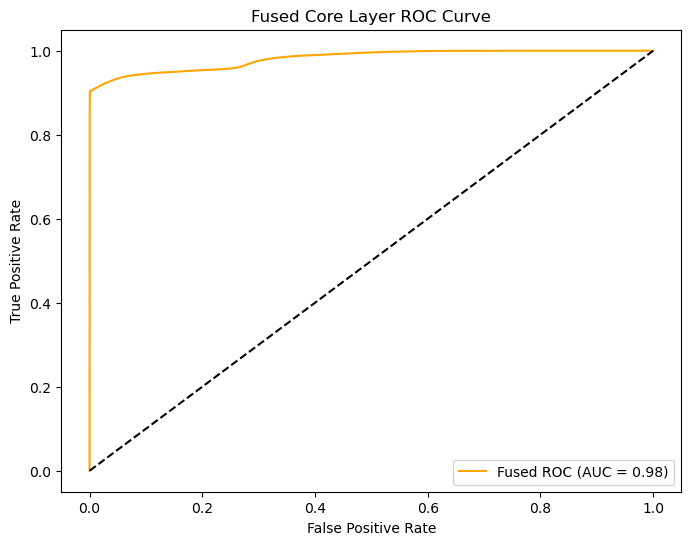


Core layer fusion results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv

Logistic Fusion Model F1 Score on Validation Set: 0.9474
Logistic Fusion Core Accuracy: 0.9690

Logistic Fusion Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573665
      Attack       0.99      0.91      0.95    696652

    accuracy                           0.97   2270317
   macro avg       0.98      0.95      0.96   2270317
weighted avg       0.97      0.97      0.97   2270317


Logistic Fusion Core Confusion Matrix:
[[1569167    4498]
 [  65911  630741]]

Best Threshold on Logistic Fusion: 0.7599999999999997


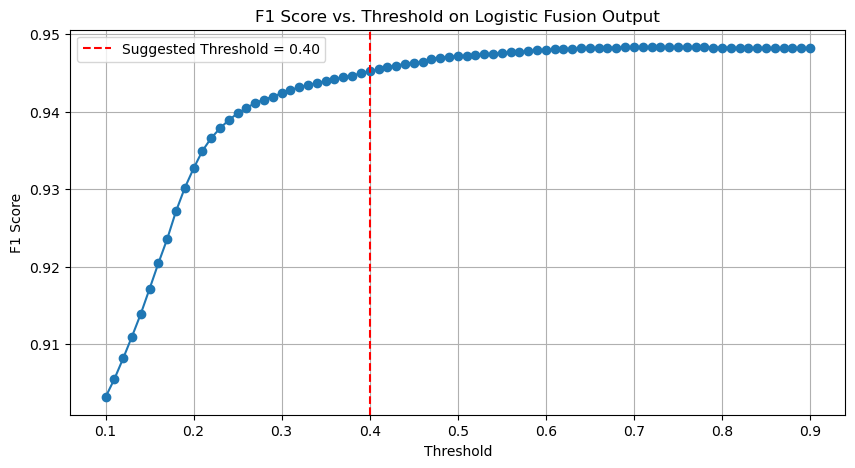

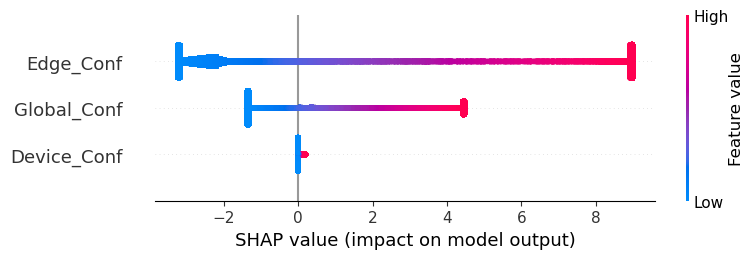

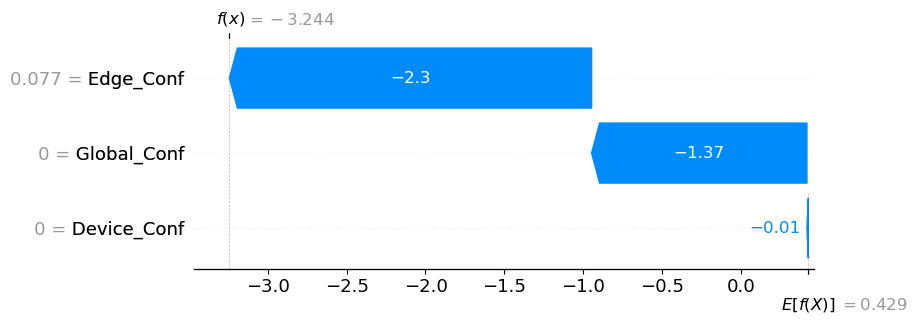


✅ CSE CIC IDS 2018 Fusion Evaluation Completed.


In [6]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import shap

# =================================================================
# Part 1: Setup and Load Data/Models (CIC IDS 2018)
# =================================================================
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH   = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# Create binary label column: 0 for benign, 1 for attack.
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)       # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)    # MLP

# =================================================================
# Part 2: Layer-wise Predictions and Fusion (Core Layer)
# =================================================================

# --- GLOBAL LAYER ---
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
X_global = df[global_features].values
y_pred_proba_global = xgb_global.predict_proba(X_global)
# Define attack confidence as 1 - probability that the model predicted "Benign" (assuming benign is index 0)
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# --- EDGE LAYER (LSTM) ---
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)
sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i:i+sequence_length] for i in range(num_samples_edge)])
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)
attack_conf_edge = 1.0 - edge_proba[:, 0]
attack_conf_edge_aligned = np.empty(X_edge.shape[0])
# For the first (sequence_length-1) rows, no prediction is available; fill with NaN then replace with 0.
attack_conf_edge_aligned[:sequence_length-1] = np.nan
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# --- DEVICE LAYER (MLP) ---
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)
device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
# Here, assume device_proba is the probability of an attack.
attack_conf_device = device_proba

# --- FUSION (Core Layer) ---
attack_conf_global = np.array(attack_conf_global)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)
attack_conf_device = np.array(attack_conf_device)

# Fusion weights (initially set as Global:0.3, Edge:0.3, Device:0.4)
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_score = (w_global * attack_conf_global +
               w_edge * attack_conf_edge_aligned +
               w_device * attack_conf_device)
fused_score = np.nan_to_num(fused_score, nan=0.0)
# Simple thresholding at 0.5 to generate fused labels
fused_label = (fused_score > 0.5).astype(int)

y_true = df["Binary_Label"].values
assert len(y_true) == len(fused_label), "Mismatch in lengths!"

acc_core = accuracy_score(y_true, fused_label)
print(f"Fused core layer accuracy: {acc_core:.4f}")

print("\nFused Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))

cm_core = confusion_matrix(y_true, fused_label)
print("\nFused Core Confusion Matrix:")
print(cm_core)

fpr_fused, tpr_fused, _ = roc_curve(y_true, fused_score)
roc_auc_fused = auc(fpr_fused, tpr_fused)
plt.figure(figsize=(8,6))
plt.plot(fpr_fused, tpr_fused, color='orange', label=f"Fused ROC (AUC = {roc_auc_fused:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fused Core Layer ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(CORE_LAYER_DIR, "core_layer_fused_roc.png"))
plt.show()

core_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf":   attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score": fused_score,
    "Fused_Label": fused_label,
    "True_Label":  y_true
})
csv_core_path = os.path.join(CORE_LAYER_DIR, "core_layer_results.csv")
core_results_df.to_csv(csv_core_path, index=False)
print(f"\nCore layer fusion results saved to: {csv_core_path}")

# =================================================================
# Part 3: Logistic Fusion for Adaptive Core Fusion
# =================================================================
X_fusion = np.column_stack((attack_conf_global, attack_conf_edge_aligned, attack_conf_device))
y_fusion = y_true

X_train, X_val, y_train, y_val = train_test_split(X_fusion, y_fusion, test_size=0.3, random_state=42)
lr_core = LogisticRegression()
lr_core.fit(X_train, y_train)

lr_preds = lr_core.predict(X_val)
lr_proba = lr_core.predict_proba(X_val)[:, 1]
f1_lr = f1_score(y_val, lr_preds)
print(f"\nLogistic Fusion Model F1 Score on Validation Set: {f1_lr:.4f}")

fused_score_lr = lr_core.predict_proba(X_fusion)[:, 1]
fused_label_lr = (fused_score_lr > 0.5).astype(int)

print(f"Logistic Fusion Core Accuracy: {accuracy_score(y_fusion, fused_label_lr):.4f}")
print("\nLogistic Fusion Core Classification Report:")
print(classification_report(y_fusion, fused_label_lr, target_names=["Benign", "Attack"]))
print("\nLogistic Fusion Core Confusion Matrix:")
print(confusion_matrix(y_fusion, fused_label_lr))

# =================================================================
# Part 4: Threshold Sensitivity on Logistic Fusion Output
# =================================================================
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = [f1_score(y_fusion, (fused_score_lr > t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold on Logistic Fusion: {best_t}")

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=0.40, color='r', linestyle='--', label='Suggested Threshold = 0.40')
plt.title("F1 Score vs. Threshold on Logistic Fusion Output")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# =================================================================
# Part 5: SHAP Analysis on Logistic Fusion Model
# =================================================================
explainer = shap.Explainer(lr_core, X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])
shap_values = explainer(X_fusion)

# Global summary plot for logistic fusion model
shap.summary_plot(shap_values, features=X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])

# Force and waterfall plots for a single instance (e.g., index 12345)
row_idx = 12345
shap.initjs()
shap.plots.force(shap_values[row_idx])
shap.plots.waterfall(shap_values[row_idx])

print("\n✅ CSE CIC IDS 2018 Fusion Evaluation Completed.")

Loading dataset...


Dataset loaded successfully. Shape: (2270317, 90)
Loading Global model...
Loading Edge model...
Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 176us/step
Basic Fusion Core Accuracy: 0.9469

Basic Fusion Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.95      0.96   1573665
      Attack       0.90      0.93      0.92    696652

    accuracy                           0.95   2270317
   macro avg       0.93      0.94      0.94   2270317
weighted avg       0.95      0.95      0.95   2270317


Basic Fusion Core Confusion Matrix:
[[1500319   73346]
 [  47113  649539]]


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 404us/step - accuracy: 0.9638 - loss: 0.1238 - val_accuracy: 0.9701 - val_loss: 0.0745
Epoch 2/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 401us/step - accuracy: 0.9677 - loss: 0.0833 - val_accuracy: 0.9702 - val_loss: 0.0727
Epoch 3/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 400us/step - accuracy: 0.9676 - loss: 0.0809 - val_accuracy: 0.9700 - val_loss: 0.0737
Epoch 4/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 400us/step - accuracy: 0.9676 - loss: 0.0800 - val_accuracy: 0.9702 - val_loss: 0.0733
Epoch 5/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 401us/step - accuracy: 0.9676 - loss: 0.0801 - val_accuracy: 0.9701 - val_loss: 0.0737
Epoch 6/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 399us/step - accuracy: 0.9676 - loss: 0.0799 - val_accuracy: 0.9700 - val_loss: 0.0725
Epoch 7/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 400us/step - accuracy: 0.9676 - loss: 0.0797 - val_accuracy: 0.9702 - val_loss: 0.0719
Epoch 8/50
49664/49664 ━━━━━━━━━━━━━━━━━━━━ 20s 400us/s

ExactExplainer explainer: 2270318it [1:09:03, 546.70it/s]                       
/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_17796/327002021.py:182: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn, features=X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])


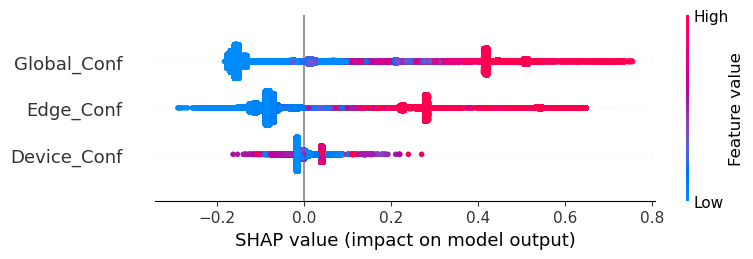

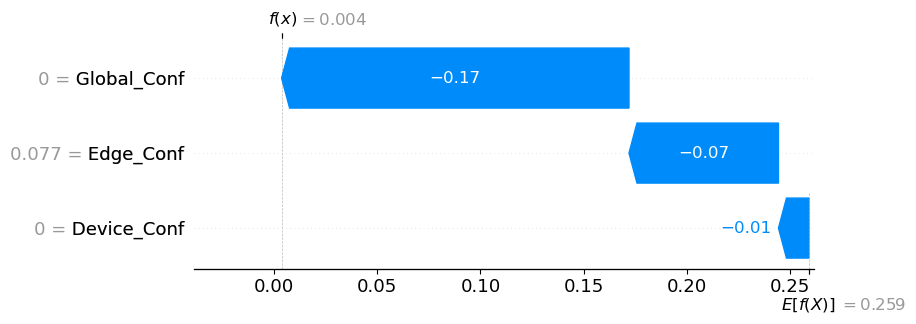


Neural fusion core results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results_neural_fusion.csv

✅ Neural Fusion Core implementation complete, Commander!


In [14]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import shap

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =================================================================
# Part 1: Setup and Load Data/Models
# =================================================================

# Define paths and directories
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH   = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

# Set the dataset path (this version is for CICIDS 2018)
DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# Create binary label: 0 = Benign, 1 = Attack (adjust if needed)
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)       # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)    # MLP

# =================================================================
# Part 2: Layer-wise Predictions and Fusion (Core Layer)
# =================================================================

# --- GLOBAL LAYER ---
# Use the exact column names as in your mapping for CICIDS 2018
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
X_global = df[global_features].values
y_pred_proba_global = xgb_global.predict_proba(X_global)
# Define attack confidence as 1.0 minus the probability that "Benign" was predicted (assumed to be at index 0)
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# --- EDGE LAYER (LSTM) ---
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)
sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i:i+sequence_length] for i in range(num_samples_edge)])
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)
attack_conf_edge = 1.0 - edge_proba[:, 0]
attack_conf_edge_aligned = np.empty(X_edge.shape[0])
attack_conf_edge_aligned[:sequence_length-1] = np.nan  # No predictions for the first (sequence_length-1) rows
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# --- DEVICE LAYER (MLP) ---
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)
device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
# Here we assume device_proba already represents the attack probability.
attack_conf_device = device_proba

# --- FUSION ---
attack_conf_global = np.array(attack_conf_global)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)
attack_conf_device = np.array(attack_conf_device)

# Use fixed fusion weights for now
w_global, w_edge, w_device = 0.3, 0.3, 0.4
fused_score = (w_global * attack_conf_global +
               w_edge * attack_conf_edge_aligned +
               w_device * attack_conf_device)
fused_score = np.nan_to_num(fused_score, nan=0.0)

# For the naive fusion, use a threshold of 0.10
best_threshold = 0.10
fused_label = (fused_score > best_threshold).astype(int)

y_true = df["Binary_Label"].values
print(f"Basic Fusion Core Accuracy: {accuracy_score(y_true, fused_label):.4f}")
print("\nBasic Fusion Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))
print("\nBasic Fusion Core Confusion Matrix:")
print(confusion_matrix(y_true, fused_label))

# =================================================================
# Part 3: Neural Fusion Core (Approach A)
# =================================================================
# Prepare fusion features by stacking the layer confidences.
X_fusion = np.column_stack((attack_conf_global, attack_conf_edge_aligned, attack_conf_device))
y_fusion = y_true

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_fusion, y_fusion, test_size=0.3, random_state=42)

# Build the neural fusion model using Keras.
def build_neural_fusion_model(input_dim=3):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

neural_fusion_model = build_neural_fusion_model(input_dim=3)
neural_fusion_model.summary()

# Train the neural fusion model.
history = neural_fusion_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                  validation_data=(X_val, y_val), verbose=1)

# Evaluate on the validation set.
loss, acc_nn = neural_fusion_model.evaluate(X_val, y_val, verbose=0)
print(f"\nNeural Fusion Core Accuracy on Validation: {acc_nn:.4f}")

# Predict on the full dataset using the neural fusion model.
fused_score_nn = neural_fusion_model.predict(X_fusion, batch_size=64).flatten()
fused_label_nn = (fused_score_nn > 0.5).astype(int)

print("\nNeural Fusion Core Classification Report:")
print(classification_report(y_fusion, fused_label_nn, target_names=["Benign", "Attack"]))
print("\nNeural Fusion Core Confusion Matrix:")
print(confusion_matrix(y_fusion, fused_label_nn))

# =================================================================
# Part 4: SHAP Analysis for Neural Fusion Model
# =================================================================
explainer_nn = shap.Explainer(neural_fusion_model, X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])
shap_values_nn = explainer_nn(X_fusion)

# Global SHAP summary plot.
shap.summary_plot(shap_values_nn, features=X_fusion, feature_names=["Global_Conf", "Edge_Conf", "Device_Conf"])

# Force and waterfall plots for a sample instance (e.g., index 12345).
row_idx = 12345
shap.initjs()
shap.plots.force(shap_values_nn[row_idx])
shap.plots.waterfall(shap_values_nn[row_idx])

# =================================================================
# Part 5: Save Neural Fusion Core Results to CSV
# =================================================================
neural_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf": attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score_NN": fused_score_nn,
    "Fused_Label_NN": fused_label_nn,
    "True_Label": y_true
})
csv_neural_path = os.path.join(CORE_LAYER_DIR, "core_layer_results_neural_fusion.csv")
neural_results_df.to_csv(csv_neural_path, index=False)
print(f"\nNeural fusion core results saved to: {csv_neural_path}")

print("\n✅ Neural Fusion Core implementation complete, Commander!")

                 Accuracy  Benign Precision  Benign Recall  Benign F1  \
Basic Fusion         95.0              97.0           95.0       96.0   
Logistic Fusion      96.9              96.0          100.0       98.0   
Neural Fusion        97.0              96.0          100.0       98.0   

                 Attack Precision  Attack Recall  Attack F1  
Basic Fusion                 90.0           93.0       92.0  
Logistic Fusion              99.0           91.0       95.0  
Neural Fusion               100.0           90.0       95.0  


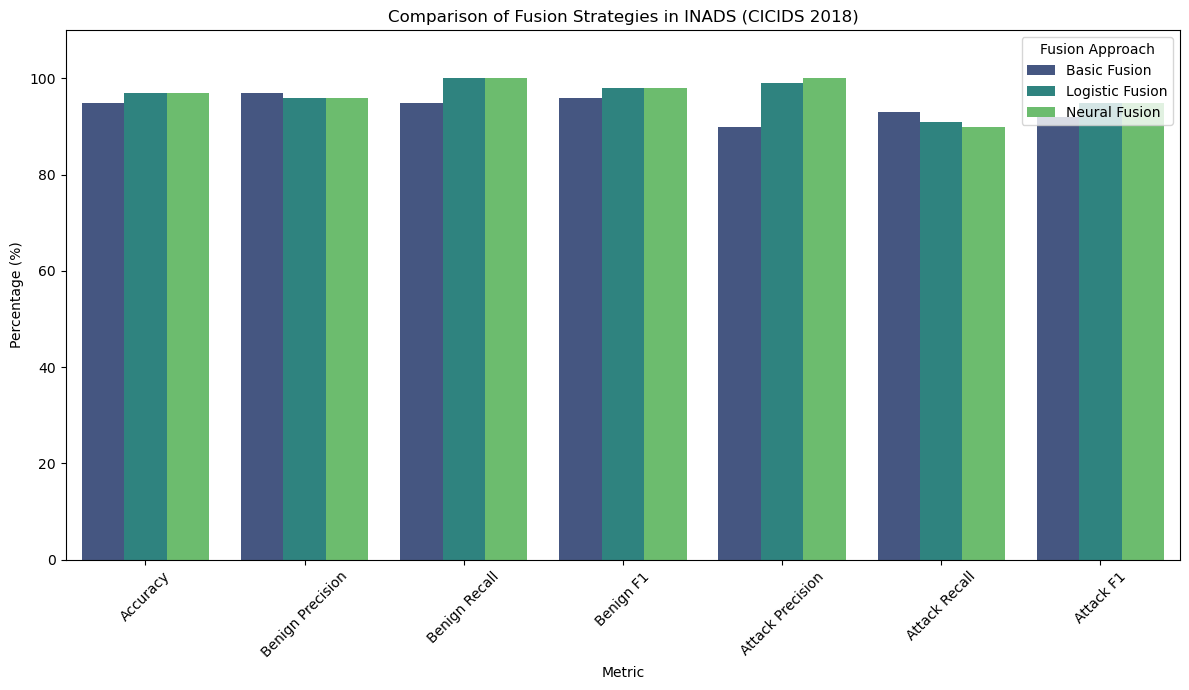

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data from our fusion experiments (values as percentages)
# These values are based on your reported metrics:
fusion_metrics = {
    "Basic Fusion": {
        "Accuracy": 95.0,
        "Benign Precision": 97.0,
        "Benign Recall": 95.0,
        "Benign F1": 96.0,
        "Attack Precision": 90.0,
        "Attack Recall": 93.0,
        "Attack F1": 92.0
    },
    "Logistic Fusion": {
        "Accuracy": 96.9,
        "Benign Precision": 96.0,
        "Benign Recall": 100.0,
        "Benign F1": 98.0,
        "Attack Precision": 99.0,
        "Attack Recall": 91.0,
        "Attack F1": 95.0
    },
    "Neural Fusion": {
        "Accuracy": 97.0,
        "Benign Precision": 96.0,
        "Benign Recall": 100.0,
        "Benign F1": 98.0,
        "Attack Precision": 100.0,
        "Attack Recall": 90.0,
        "Attack F1": 95.0
    }
}

# Convert the dictionary to a DataFrame for easy plotting.
metrics_df = pd.DataFrame(fusion_metrics).T  # transpose to have models as rows
metrics_df = metrics_df[['Accuracy', 'Benign Precision', 'Benign Recall', 'Benign F1',
                         'Attack Precision', 'Attack Recall', 'Attack F1']]
print(metrics_df)

# Prepare data for grouped bar plot.
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Fusion Model'})
melted_df = pd.melt(metrics_df, id_vars=['Fusion Model'], 
                    value_vars=metrics_df.columns[1:],
                    var_name='Metric', value_name='Value')

# Create a grouped bar chart
plt.figure(figsize=(12, 7))
sns.barplot(data=melted_df, x='Metric', y='Value', hue='Fusion Model', palette='viridis')
plt.title("Comparison of Fusion Strategies in INADS (CICIDS 2018)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.legend(title="Fusion Approach", loc='upper right')
plt.tight_layout()
plt.show()